# Aim: To bin the stars on the basis of distance of star

## In this, i tried to bin stars on the basis of their distance. I will find red stars for 5 stars in each bin firstly, after that i will try to include more stars and will find the average number of stars within the bin.

In [1]:
# importing all necessary library

from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

### $\textbf{importing csv file of 1m sources containing Gaia data for plotting HR diagram}$


In [2]:
# importing csv file of 1m sources containing Gaia data for plotting HR diagram
filename = '1M.csv'
df1 = pd.read_csv(filename)

# filtering data on the basis of parallax error so that we can get better observed sources
df = df1[df1['parallax_error']< 0.1]
df = df.reset_index(drop=True)


gk_1m = df["phot_g_mean_mag"] - df["ks_m"]
mg = df["mg"]

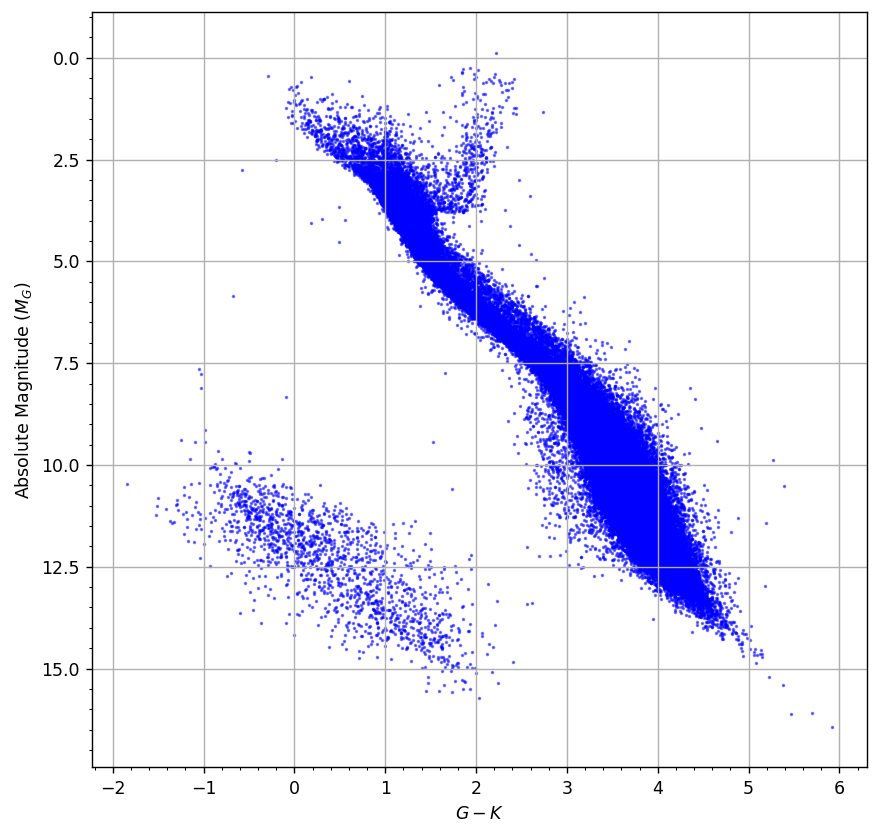

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 125, figsize = (8, 8))
ax.set_xlabel(r"$G - K$")
ax.set_ylabel(r"Absolute Magnitude ($M_G$)")
ax.scatter(gk_1m, mg, s = 1, alpha= 0.5, c = 'blue')
ax.minorticks_on()
ax.grid(True)
ax.set_ylim(max(mg) + 1, min(mg) - 1)
plt.show()

### $\textbf{Boundary equation}$

In [4]:
# Defining the equation of straight line for the boundries

#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------


def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x


#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------

### $\textbf{Plotting those boundary line at HR Diagram}$

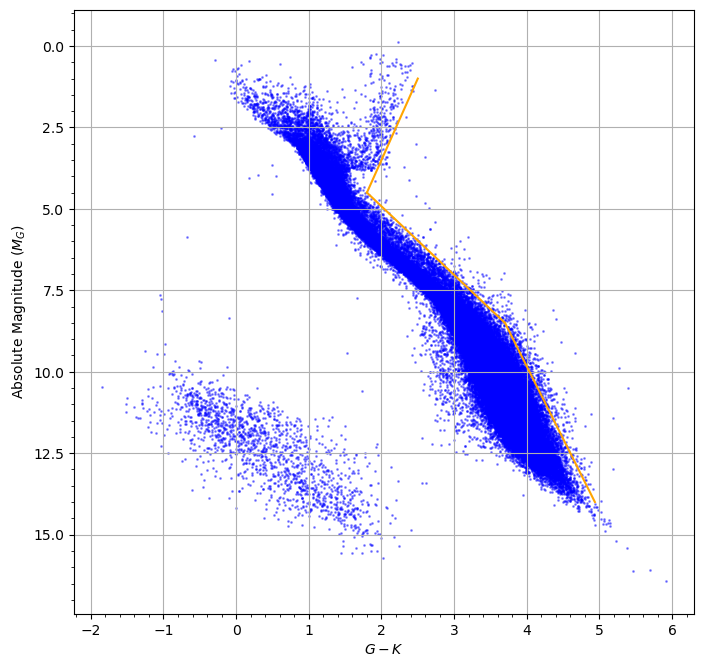

In [5]:
# defining the limit of absolute magnitude just for plotting the boundries line
y_values1 = np.linspace(1, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 14.0, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)
ax.set_xlabel(r"$G - K$")
ax.set_ylabel(r"Absolute Magnitude ($M_G$)", fontsize = 10)

# Plotting the HR diagram for 1M sources
ax.scatter(gk_1m, mg, s = 1, alpha = 0.4, c = 'blue')

# plotting the boundries using the eqaution of straight line
ax.plot(equation1(y_values1), y_values1,  color = 'orange')
ax.plot(equation2(y_values2), y_values2,  color = 'orange')
ax.plot(equation3(y_values3), y_values3, color = 'orange')

ax.minorticks_on()
ax.grid(True)
ax.set_ylim(max(mg)+1, min(mg)-1)
plt.show()

### $ \bm{\textbf{Extracting data from the gaia table around a star having ra and dec}}$

In [6]:
# defining a function for extracting data of stars from GAIA database around a choosen Object(Star or Herbig Ae/Be star)

# The function will take input query size, ra, dec of the centered boject and radius of the circle
# It will give output of ojects around that star in table form

def get_gaia_result(query_size, ra_obj, dec_obj, radius_deg):
    #from astroquery.gaia import Gaia

    query = """SELECT TOP {}""".format(query_size) + """
        g.source_id, g.ra, g.dec, g.parallax, g.parallax_error, d3.r_med_photogeo, d3.r_lo_photogeo, d3.r_hi_photogeo,(d3.r_hi_photogeo - d3.r_lo_photogeo)/(2 * d3.r_med_photogeo) AS dist_frac, g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag, g.bp_rp, g.phot_g_mean_mag + 5*log10(g.parallax) - 10 AS mv,
        w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro, tmass.j_m, tmass.h_m, tmass.ks_m
        FROM gaiadr3.gaia_source as g, gaiadr3.allwise_best_neighbour as x, gaiadr1.allwise_original_valid as w, gaiadr3.tmass_psc_xsc_best_neighbour as t, gaiadr3.tmass_psc_xsc_join AS tt,  gaiadr1.tmass_original_valid as tmass, external.gaiaedr3_distance AS d3
        WHERE CONTAINS(POINT(g.ra, g.dec), CIRCLE({}""".format(ra_obj) + """, {}""".format(dec_obj)+""", {}""".format(radius_deg) + """ )) = 1 AND g.parallax > 0.0 AND
        g.parallax IS NOT NULL AND g.bp_rp IS NOT NULL AND ((g.source_id = x.source_id AND x.allwise_oid = w.allwise_oid) AND (g.source_id = t.source_id AND t.original_ext_source_id = tt.original_psc_source_id AND  tt.original_psc_source_id = tmass.designation)) AND (g.source_id = d3.source_id)
        """
    job = Gaia.launch_job(query)
    result = job.get_results()

    return result

### $\textbf{Counting function}$

In [7]:
# Defining a function which will count red object
# just we need to pass list of object(stars) with G-K as X- coordinate and Absolute Magnitude(Mv) as Y-coordinate 

def counting_fun(her_mg, her_gk):

    count_red = 0

    for i in range(len(her_mg)):

        if her_mg[i] <= 4.5:
            if her_gk[i] >= equation1(her_mg[i]):
                count_red = count_red + 1
        
        if 4.5 < her_mg[i] and her_mg[i] <= 8.5:
            if her_gk[i] >= equation2(her_mg[i]):
                count_red = count_red + 1

        if 8.5 < her_mg[i]:
            if her_gk[i] >= equation3(her_mg[i]):
                count_red = count_red + 1

    return count_red



def red_fraction(mg, gk):
    red_frac = counting_fun(mg, gk)/len(gk)
    return red_frac

### $\textbf{Importing a list of herbig Ae/Be stars from "Vioque M." Catalog}$

### $\textbf{J/A+A/620/A128/hqsample}$

In [8]:
df_herb = pd.read_csv("all_herbig star.csv")

In [9]:
df_herb.head()

,recno,Name,RAICRS,DEICRS,plx,e_plx,Dist,E_Dist,e_Dist,Teff,...,E(H),E(Ks),E(W1),E(W2),E(W3),E(W4),The,SimbadName,_RA_icrs,_DE_icrs
0,1,AB Aur,73.941250,30.551111,6.139962,0.057095,162.9,2.6,2.4,9500,...,6.01,13.23,28.77,NaN,240.49,2244.34,Yes,AB Aur,73.941250,30.551111
1,2,AK Sco,253.686667,-36.888611,7.112617,0.062137,140.6,2.1,2.0,6250,...,1.88,3.14,7.78,11.61,49.83,400.83,,AK Sco,253.686667,-36.888611
2,3,AS 310,278.338333,-4.968333,0.390395,0.045659,2108.4,354.5,235.6,24500,...,0.71,0.81,NaN,NaN,NaN,NaN,Yes,AS 310,278.338333,-4.968333
3,4,AS 470,324.059167,57.358611,0.137445,0.026643,4039.6,616.9,439.7,8150,...,1.28,1.71,2.15,2.77,3.21,5.36,,AS 470,324.059167,57.358611
4,5,AS 477,328.142083,47.228889,1.289931,0.028924,773.0,30.2,26.6,10000,...,NaN,NaN,27.30,59.04,104.62,475.86,Yes,AS 477,328.142083,47.228889


### $\textbf{Filtering out these herbig stars on the basis of different parameters}$

$\textbf{Like - parallax error, error in distance, within 500 parsec}$

In [10]:
# filtering out on the basis of parallax error i.e. parallax_error < 0.1
df_herb = df_herb[df_herb["e_plx"]< 0.1] 

# resetting the index of the table
df_herb = df_herb.reset_index(drop=True)
df_herb

,recno,Name,RAICRS,DEICRS,plx,e_plx,Dist,E_Dist,e_Dist,Teff,...,E(H),E(Ks),E(W1),E(W2),E(W3),E(W4),The,SimbadName,_RA_icrs,_DE_icrs
0,1,AB Aur,73.941250,30.551111,6.139962,0.057095,162.9,2.6,2.4,9500,...,6.01,13.23,28.77,NaN,240.49,2244.34,Yes,AB Aur,73.941250,30.551111
1,2,AK Sco,253.686667,-36.888611,7.112617,0.062137,140.6,2.1,2.0,6250,...,1.88,3.14,7.78,11.61,49.83,400.83,,AK Sco,253.686667,-36.888611
2,3,AS 310,278.338333,-4.968333,0.390395,0.045659,2108.4,354.5,235.6,24500,...,0.71,0.81,NaN,NaN,NaN,NaN,Yes,AS 310,278.338333,-4.968333
3,4,AS 470,324.059167,57.358611,0.137445,0.026643,4039.6,616.9,439.7,8150,...,1.28,1.71,2.15,2.77,3.21,5.36,,AS 470,324.059167,57.358611
4,5,AS 477,328.142083,47.228889,1.289931,0.028924,773.0,30.2,26.6,10000,...,NaN,NaN,27.30,59.04,104.62,475.86,Yes,AS 477,328.142083,47.228889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,214,VV Ser,277.199583,0.144444,2.380821,0.045769,419.7,14.0,12.6,13800,...,8.83,21.97,46.08,121.07,428.03,1766.30,Yes,VV Ser,277.199583,0.144444
189,215,VX Cas,7.877917,61.980833,1.861109,0.036601,536.6,18.3,16.4,10000,...,4.62,11.25,27.13,45.17,276.95,2735.55,Yes,VX Cas,7.877917,61.980833
190,216,WRAY 15-1435,243.277917,-50.388889,0.466778,0.048112,1858.3,300.1,200.1,24500,...,2.88,3.34,4.39,7.36,192.05,3602.51,,WRAY 15-1435,243.277917,-50.388889
191,217,WW Vul,291.495000,21.208611,1.983958,0.036763,503.5,16.2,14.5,8970,...,4.60,10.53,17.32,32.02,231.68,1366.23,Yes,WW Vul,291.495000,21.208611


In [11]:

herbig_within_500 = df_herb[["Name", "RAICRS", "DEICRS", "Dist", "E_Dist", "e_Dist"]]

# Creating a column for storing Maximum possible distance of the herbig star from the given error

herbig_within_500["Max_Dist"] = herbig_within_500["Dist"] + herbig_within_500["E_Dist"]


# Creating a column for storing Minimum possible distance of the herbig star from the given error
herbig_within_500["Min_Dist"] = herbig_within_500["Dist"]- herbig_within_500["e_Dist"]

/tmp/ipykernel_4155/3313157933.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  herbig_within_500["Max_Dist"] = herbig_within_500["Dist"] + herbig_within_500["E_Dist"]
/tmp/ipykernel_4155/3313157933.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  herbig_within_500["Min_Dist"] = herbig_within_500["Dist"]- herbig_within_500["e_Dist"]


### $\textbf{Filtering out on the basis of distance error}$

In [12]:
herbig_within_500 = herbig_within_500[(herbig_within_500["Max_Dist"] - herbig_within_500["Min_Dist"])/(2*herbig_within_500["Dist"])< 0.1]

### $\textbf{Importing 5 Random and 5 Herbig Ae/Be Stars}$


$\textbf{first bin --- distance wthin,  0 - 500 parsec}$

In [13]:

# Aranging the data in ascending order of distance
herbig_within_500 = herbig_within_500.sort_values(by="Dist")
herbig_within_500.reset_index(drop=True)

,Name,RAICRS,DEICRS,Dist,E_Dist,e_Dist,Max_Dist,Min_Dist
0,HD 100453,173.272917,-54.324722,104.2,0.7,0.7,104.9,103.5
1,HD 104237,180.020417,-78.193056,108.4,1.1,1.1,109.5,107.3
2,HD 100546,173.355417,-70.194722,110.0,1.0,1.0,111.0,109.0
3,HD 141569,237.490417,-3.921389,110.6,0.9,0.9,111.5,109.7
4,HD 169142,276.124167,-29.780556,114.0,1.4,1.3,115.4,112.7
...,...,...,...,...,...,...,...,...
144,PDS 34,132.493750,-45.885000,2132.9,135.9,111.8,2268.8,2021.1
145,MWC 655,339.632500,55.834722,2170.0,249.6,182.0,2419.6,1988.0
146,PDS 344,175.136667,-64.535000,2439.5,173.0,139.7,2612.5,2299.8
147,HBC 7,10.855417,61.639722,2757.3,252.4,194.4,3009.7,2562.9


(array([1.37354289e-03, 5.72309536e-05, 1.08738812e-03, 1.77415956e-03,
        2.28923814e-04, 3.43385721e-04, 6.29540489e-04, 4.57847629e-04,
        8.58464304e-04, 4.57847629e-04, 4.00616675e-04, 3.43385721e-04,
        1.71692861e-04, 2.28923814e-04, 2.28923814e-04, 2.28923814e-04,
        5.72309536e-05, 2.28923814e-04, 4.00616675e-04, 1.71692861e-04,
        5.72309536e-05, 5.72309536e-05, 2.28923814e-04, 0.00000000e+00,
        0.00000000e+00, 1.14461907e-04, 5.72309536e-05, 1.14461907e-04,
        0.00000000e+00, 5.72309536e-05, 1.71692861e-04, 1.14461907e-04,
        0.00000000e+00, 1.14461907e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.72309536e-05, 0.00000000e+00, 1.14461907e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.72309536e-05]),
 array([ 104.2  ,  194.734,  285.268,  375.802,  466.336,  556.87 ,
         647.404,  737.938

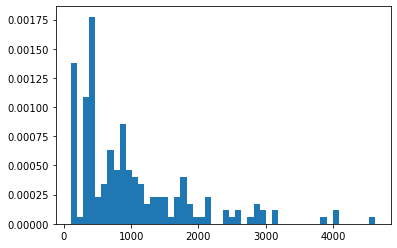

In [104]:
plt.hist(df_herb["Dist"], bins=50, density=True)

In [14]:
herbig_within_500 = herbig_within_500[herbig_within_500["Dist"]<500.0]
herbig_within_500 = herbig_within_500.reset_index(drop=True)

### $\textbf{Total number of herbig stars within 100-500 pc is 76.}$

In [15]:
herbig_within_500

,Name,RAICRS,DEICRS,Dist,E_Dist,e_Dist,Max_Dist,Min_Dist
0,HD 100453,173.272917,-54.324722,104.2,0.7,0.7,104.9,103.5
1,HD 104237,180.020417,-78.193056,108.4,1.1,1.1,109.5,107.3
2,HD 100546,173.355417,-70.194722,110.0,1.0,1.0,111.0,109.0
3,HD 141569,237.490417,-3.921389,110.6,0.9,0.9,111.5,109.7
4,HD 169142,276.124167,-29.780556,114.0,1.4,1.3,115.4,112.7
...,...,...,...,...,...,...,...,...
71,HD 36408,83.058750,17.058056,435.1,34.5,27.1,469.6,408.0
72,HD 290500,82.450417,-0.395278,438.3,23.6,19.9,461.9,418.4
73,HD 290409,81.772917,0.418889,454.9,31.0,25.1,485.9,429.8
74,XY Per A,57.401250,38.981944,459.1,34.6,27.4,493.7,431.7


### $\textbf{This is the plot of all Herbig Ae/Be Stars}$

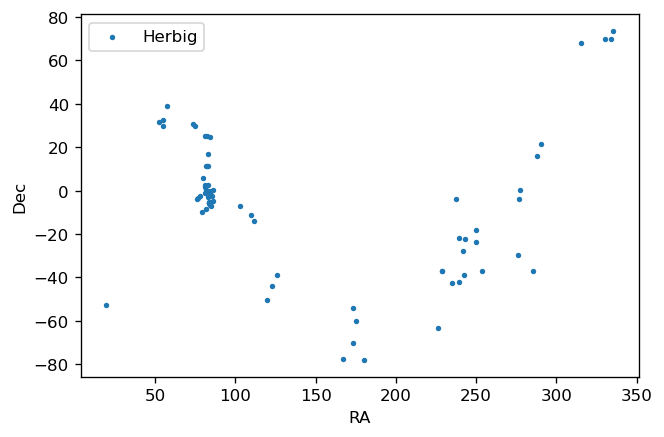

In [16]:
plt.figure(dpi = 120)
plt.scatter(herbig_within_500.RAICRS, herbig_within_500.DEICRS, s = 5,label = 'Herbig')
#plt.scatter(rnd_star20.ra, rnd_star20.dec, label = 'Random')
plt.legend()
plt.ylabel("Dec")
plt.xlabel("RA")
plt.show()

### $\textbf{Importing a list of random star}$

In [17]:
df_rand_all = pd.read_csv("test_star.csv")
df_rand_all.head()

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,phot_g_mean_mag
0,1934658092817644928,343.009122,43.312519,9.684125,0.142506,107.303535,105.959970,108.506714,4.192946
1,1451072022557616000,209.142558,27.491873,5.198965,0.146093,189.101850,185.861240,192.102070,4.436439
2,1547080896862730112,184.952870,48.984171,4.878467,0.138663,194.069200,191.403100,196.837040,4.445887
3,1372702716380418688,237.808001,35.655882,33.232806,0.108291,29.973818,29.905025,30.046097,4.460237
4,2911168969701511424,90.815329,-26.284174,8.127429,0.103540,128.580900,127.537250,129.590520,4.486209


### $\textbf{filtering out the data}$

In [18]:
df_rand = df_rand_all[(df_rand_all["parallax_error"] < 0.1) & (df_rand_all["r_med_photogeo"] < 500.0)]

In [19]:
df_rand = df_rand[((df_rand["r_hi_photogeo"] - df_rand["r_lo_photogeo"])/(2*df_rand["r_med_photogeo"])) < 0.1]

In [20]:
df_rand

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,phot_g_mean_mag
8,2143019566369485440,288.479586,57.704764,19.432855,0.098815,51.540665,51.221886,51.838688,4.606394
13,5276027024288944128,124.578582,-65.613098,11.021877,0.098481,91.461820,91.015920,91.979210,4.674393
16,5838154100636182016,181.956237,-75.366935,6.910939,0.091615,151.324050,149.836260,152.871800,4.694582
19,2087828961746272768,300.339958,50.104717,7.227106,0.085286,138.095280,136.797410,139.108370,4.705251
20,4976574143405173504,0.333882,-50.337319,5.158155,0.099975,185.544340,183.645310,188.155410,4.707014
...,...,...,...,...,...,...,...,...,...
999988,6447711046284095104,301.255599,-57.142653,5.282354,0.037899,192.468640,191.965520,192.898640,10.949389
999991,291499292940592640,26.579654,25.098231,8.206038,0.046091,120.941605,120.722565,121.188820,10.949393
999993,4154417484853608576,274.713102,-10.506375,2.016494,0.054263,484.624630,480.908940,488.696530,10.949393
999994,675227412222354048,118.887687,23.508739,3.659743,0.037046,266.092650,263.830380,268.221920,10.949394


In [21]:
df_rand = df_rand[df_rand["r_med_photogeo"]>100.0]


In [22]:
df_rand = df_rand.reset_index(drop=True)

### $\textbf{selecting only top 100 rows from the dataframe}$

In [23]:
randstar_100 = df_rand.head(100)

In [24]:
randstar_100 = randstar_100.sort_values(by = "r_med_photogeo")
randstar_100 = randstar_100.reset_index(drop=True)

In [25]:
pd.set_option('display.max_rows', 100)
randstar_100

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,phot_g_mean_mag
0,2267990637800956416,281.444946,74.085901,9.760830,0.059265,102.817530,102.005940,103.403170,4.957585
1,477209491229638528,65.167732,65.140422,9.490805,0.096039,106.125250,105.402030,106.787660,5.018244
2,4534818718162962304,284.939929,26.230357,9.768857,0.096862,106.651010,105.978010,107.322980,4.817640
3,4568140654982359424,256.574738,22.083991,9.301517,0.075648,107.419930,106.897026,107.955154,5.105988
4,4784427339626712704,70.693188,-50.481186,9.586010,0.096362,108.589310,107.613180,109.557430,4.999612
5,1366858193604257792,264.157097,48.585903,9.336958,0.073018,109.688760,109.006714,110.307490,4.965094
6,2142873125164535296,287.919322,56.859405,9.153303,0.086734,111.705400,110.660675,112.839740,4.821311
7,4581613864310894592,265.617916,24.563610,8.855957,0.095868,114.292100,113.355460,114.986570,4.973442
8,5512568607203077120,121.265474,-53.107933,8.622714,0.064121,116.624030,115.945206,117.265810,5.055114
9,2901273846086933888,84.957580,-32.629352,8.644626,0.068243,117.141655,116.475586,117.889620,5.174418


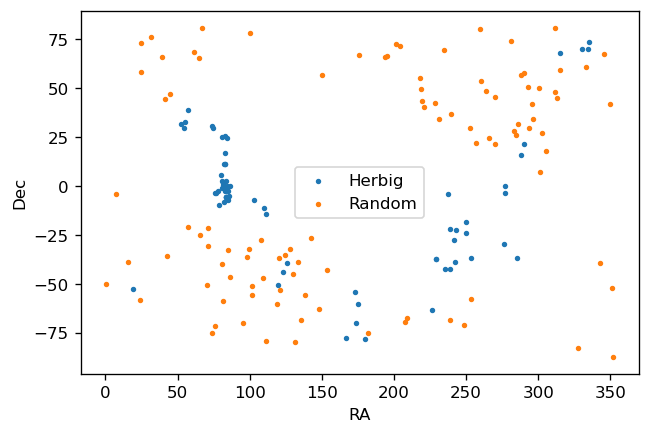

In [26]:
plt.figure(dpi = 120)
plt.scatter(herbig_within_500.RAICRS, herbig_within_500.DEICRS, s = 5,label = 'Herbig')
plt.scatter(randstar_100["ra"], randstar_100["dec"], label = 'Random', s = 5)
plt.legend()
plt.ylabel("Dec")
plt.xlabel("RA")
plt.show()

## $\textbf{finding the fraction of red of red star for 5 random stars and 5 herbig stars}$

Keeping them in about the same distance

In [27]:
herb5 = herbig_within_500.iloc[[0, 23, 24, 42, 75]]
star5 = randstar_100.iloc[[0, 48, 75, 94, 99]]
herb5 = herb5.reset_index(drop=True)
star5 = star5.reset_index(drop=True)

In [28]:
herb5

,Name,RAICRS,DEICRS,Dist,E_Dist,e_Dist,Max_Dist,Min_Dist
0,HD 100453,173.272917,-54.324722,104.2,0.7,0.7,104.9,103.5
1,HD 97048,167.013333,-77.654722,184.8,2.2,2.1,187.0,182.7
2,HD 179218,287.797083,15.787500,266.0,5.6,5.2,271.6,260.8
3,BO Cep,334.225417,70.062500,374.5,4.7,4.5,379.2,370.0
4,HD 36917,83.695833,-5.570833,474.0,29.3,24.1,503.3,449.9


In [29]:
star5

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,phot_g_mean_mag
0,2267990637800956416,281.444946,74.085901,9.760830,0.059265,102.81753,102.00594,103.40317,4.957585
1,4807445203237266944,80.850251,-39.678391,5.660871,0.092097,186.14750,184.61987,187.73296,4.778556
2,4717433855627617152,24.186840,-58.270968,3.956416,0.098888,267.50058,263.13376,271.36170,5.139260
3,2047135280516690944,296.159071,34.414174,2.875956,0.099060,374.86493,368.74805,380.33554,5.019116
4,1836489640252776576,302.949899,26.808947,1.932816,0.077865,488.34436,473.06480,503.21020,5.007190


### $\textit{Plotting these stars in ra-dec plot and in galactic coordinate}$

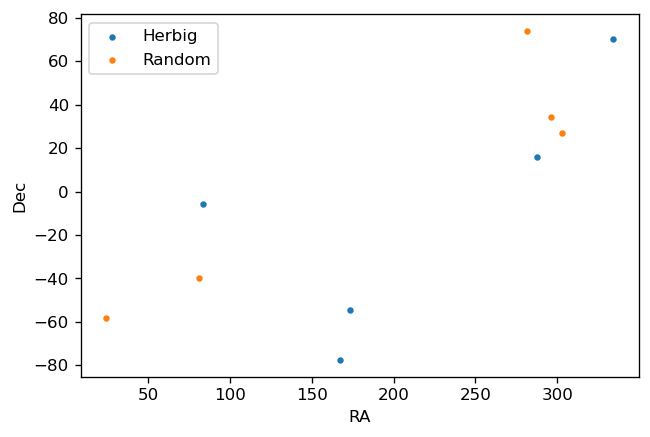

In [30]:
plt.figure(dpi = 120)
plt.scatter(herb5.RAICRS, herb5.DEICRS, s = 8,label = 'Herbig')
plt.scatter(star5["ra"], star5["dec"], label = 'Random', s = 8)
plt.legend()
plt.ylabel("Dec")
plt.xlabel("RA")
plt.show()

In [31]:
one_coord = SkyCoord(df.ra, df.dec, unit = (u.deg, u.deg))
herb_coord= SkyCoord(herb5.RAICRS, herb5.DEICRS, unit = (u.deg, u.deg))
rand_coord = SkyCoord(star5.ra, star5.dec, unit = (u.deg, u.deg))

# Converting to galactic coordinate in degrees

one_gal = one_coord.transform_to('galactic')
herb_gal = herb_coord.transform_to('galactic')
rand_gal = rand_coord.transform_to('galactic')


l_one = one_gal.l.radian
l_one[l_one > np.pi] -= 2.0*np.pi
b_one = one_gal.b.radian


l_herb = herb_gal.l.radian
l_herb[l_herb > np.pi] -= 2.0*np.pi
b_herb = herb_gal.b.radian


l_rand = rand_gal.l.radian
l_rand[l_rand > np.pi] -= 2.0*np.pi
b_rand = rand_gal.b.radian



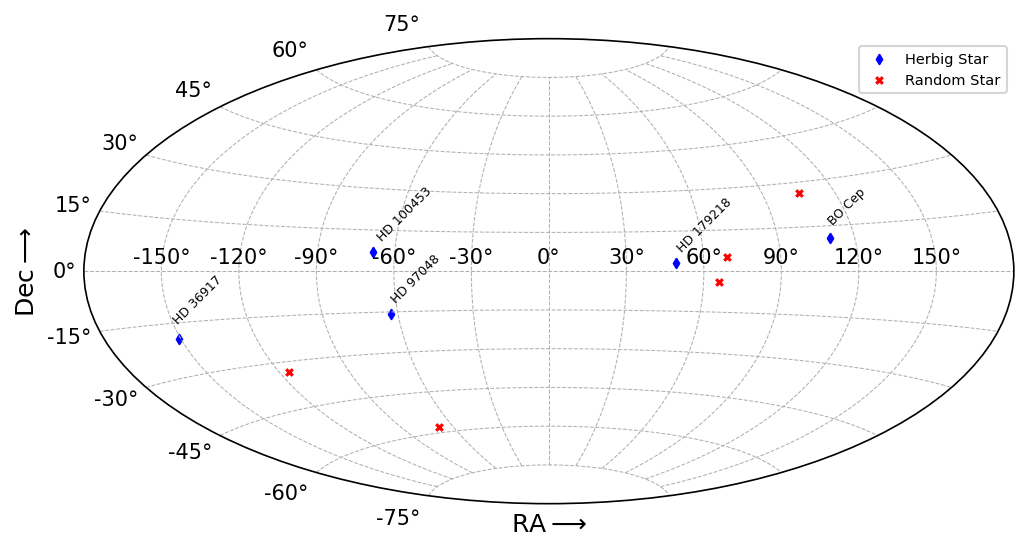

In [32]:
fig = plt.figure(figsize = [8, 5], dpi = 150)
ax = fig.add_subplot(1, 1, 1, projection='aitoff')
# ax.scatter(l_one, b_one, s = 1, color = 'orange', alpha = 0.1 )
ax.scatter(l_herb, b_herb, s = 10, color ='blue', marker = 'd', label = 'Herbig Star')
ax.scatter(l_rand, b_rand, s = 10, color = 'red', marker = "x", label = 'Random Star')
for i in range(len(l_herb)):
    ax.text(l_herb[i], b_herb[i]+ 0.08, '{}'.format(herb5["Name"][i]), fontsize = 6, rotation = 45)
ax.legend(fontsize = 7)
ax.minorticks_on()
ax.grid(True, linewidth = 0.5, linestyle = '--')
ax.set_xlabel(r'$\mathrm{RA}\longrightarrow$')
ax.xaxis.label.set_fontsize(12)
ax.set_ylabel(r'$\mathrm{Dec}\longrightarrow$')
ax.yaxis.label.set_fontsize(12)
# plt.savefig('posi.pdf', dpi = 500)
plt.show()


### $\textit{Plot of ra-distance and dec-distance}$

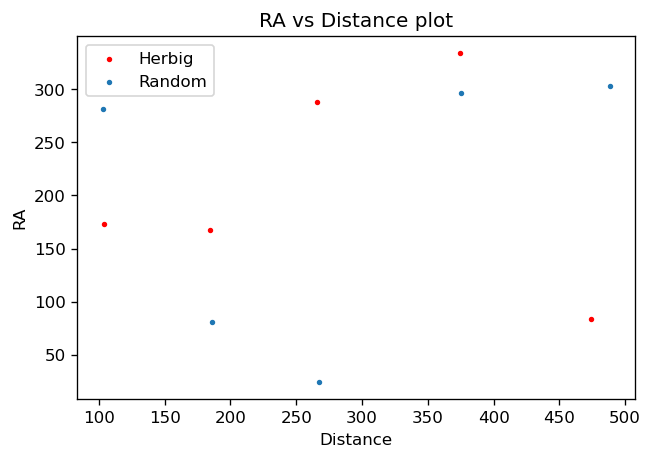

In [33]:
plt.figure(dpi = 120)
plt.title("RA vs Distance plot")
plt.scatter(herb5.Dist, herb5.RAICRS,  s = 5,label = 'Herbig',c = 'r')
plt.scatter(star5["r_med_photogeo"], star5["ra"],  label = 'Random', s = 5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("RA")
plt.show()


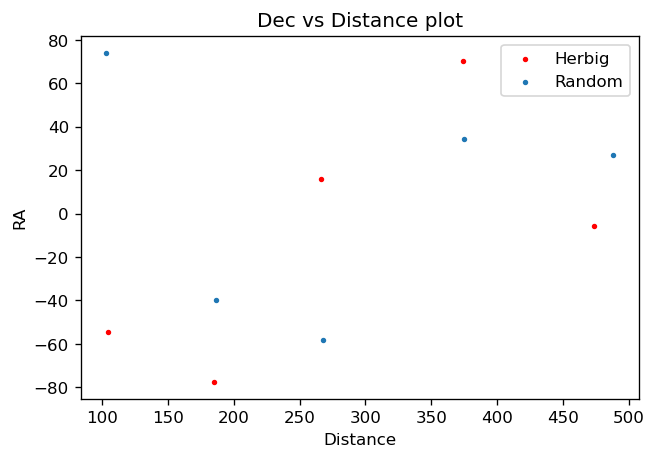

In [34]:
plt.figure(dpi = 120)
plt.title("Dec vs Distance plot")
plt.scatter(herb5.Dist, herb5.DEICRS,  s = 5,label = 'Herbig',c = 'r')
plt.scatter(star5["r_med_photogeo"], star5["dec"],  label = 'Random', s = 5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("RA")
plt.show()

### $\textit{Defining a function for plotting HR Diagram, ra vs distance diagram}$

In [35]:
def plot_function(ra, dec, dist, id):


    rad = 10.0 
    result = get_gaia_result(10000, ra, dec, rad/60.0)
    result = result[result["parallax_error"] < 0.3]


    res_gk = result["phot_g_mean_mag"] - result["ks_m"]
    res_mg = result["mv"]
    red_star = counting_fun(res_mg, res_gk)
    
    fig = plt.figure(figsize=(10,12), dpi=125)
    grid = plt.GridSpec(5, 3, wspace=0.4, hspace=0.4)
    # make subplots
    ax1 = plt.subplot(grid[0:3, 0:2])
    ax2 = plt.subplot(grid[3, 0:])
    ax3 = plt.subplot(grid[4, 0:])

    
    ax1.set_title("For star, Source_id/Name = {}".format(id), fontsize = 8)
    ax1.scatter(gk_1m, mg, c = 'blue', s=1, alpha=0.3)
    ax1.scatter(res_gk, res_mg, c = 'red', s = 5, label = 'red star = {}'.format(red_star))
    ax1.minorticks_on()
    ax1.grid(True)
    ax1.legend()
    ax1.set_ylim(max(df.mg)+1, -5)
    ax1.set_xlabel(r"$G - K~~\longrightarrow$", fontsize = 8)
    ax1.set_ylabel(r"Absolute Magnitude (G)$\longrightarrow$", fontsize = 7)
    ax1.plot(equation1(y_values1), y_values1,  color = 'orange')
    ax1.plot(equation2(y_values2), y_values2,  color = 'orange')
    ax1.plot(equation3(y_values3), y_values3, color = 'orange')

    

    ax2.scatter(result["r_med_photogeo"], result["ra"], c = 'red', s = 5)
    ax2.scatter(dist, ra, c = 'blue', s = 10)
    ax2.set_xlabel(r"Distance in parsec $\longrightarrow$", fontsize = 6)
    ax2.set_ylabel(r"ra $\longrightarrow$")

    # Filtering out the value 
    frac = 0.2
    result = result[result["dist_frac"] < frac]

    res_gk = result["phot_g_mean_mag"] - result["ks_m"]
    res_mg = result["mv"]
    red_star = counting_fun(res_mg, res_gk)

    ax3.set_title("Stars after filterig out distance error, dist_error < {}".format(frac), fontsize = 6)
    ax3.scatter(result["r_med_photogeo"], result["ra"], c = 'green', s = 5, label = "No. of red star = {}".format(red_star))
    ax3.scatter(dist, ra, c = 'blue', s = 10)
    ax3.set_xlabel(r"Distance in parsec $\longrightarrow$", fontsize = 8)
    ax3.set_ylabel(r"ra $\longrightarrow$", fontsize = 8)
    ax3.legend()
    ax2.minorticks_on()
    ax3.minorticks_on()
    plt.show()

### $\textbf{Testing for a random star and a herbig star}$

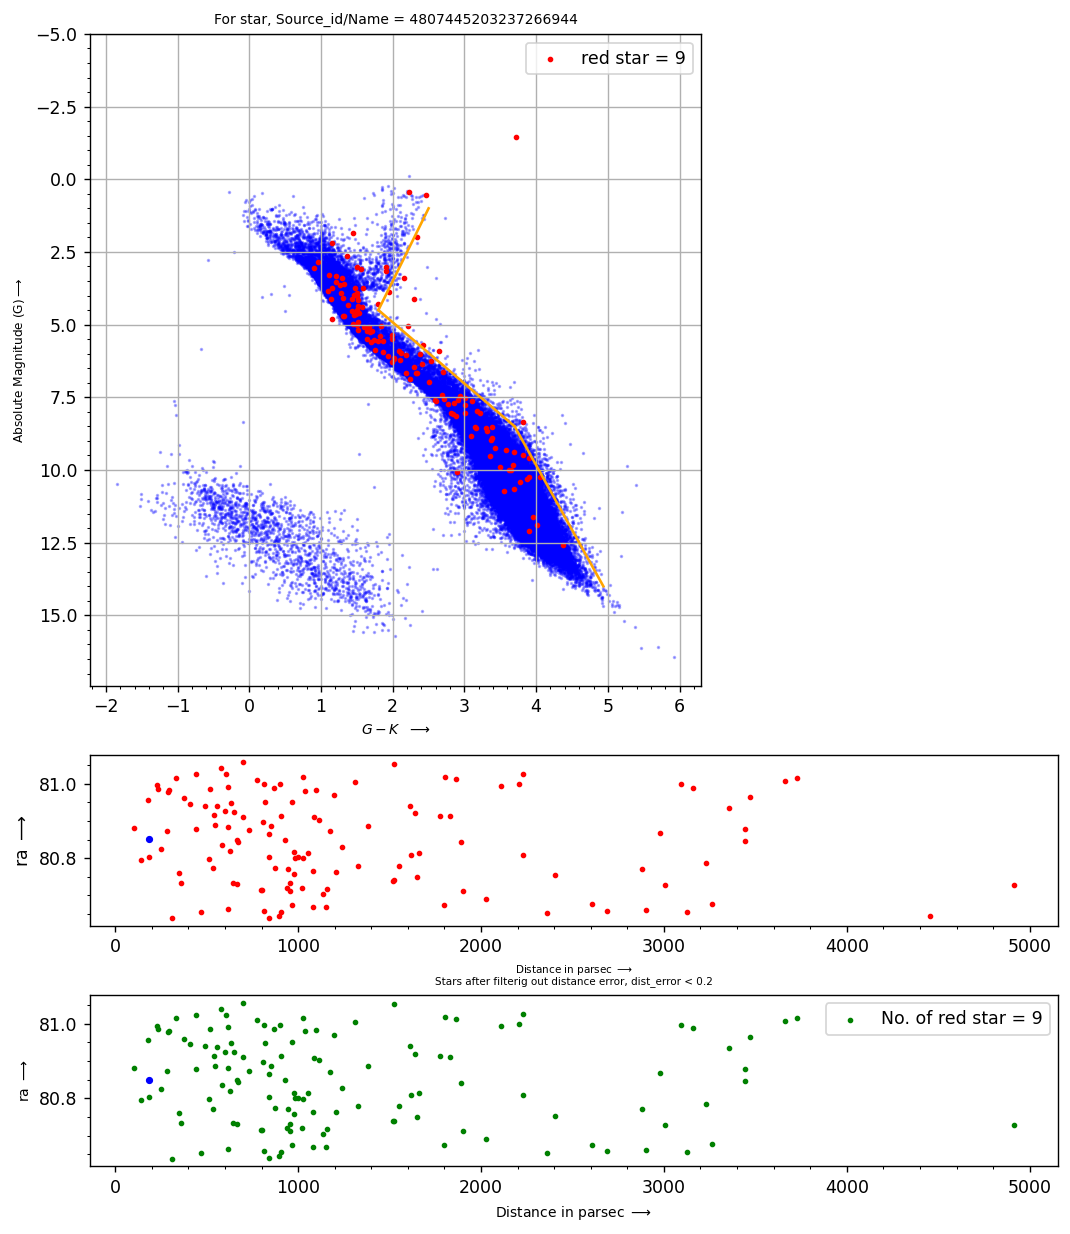

In [36]:
plot_function(star5["ra"][1], star5["dec"][1], star5["r_med_photogeo"][1], star5["source_id"][1])

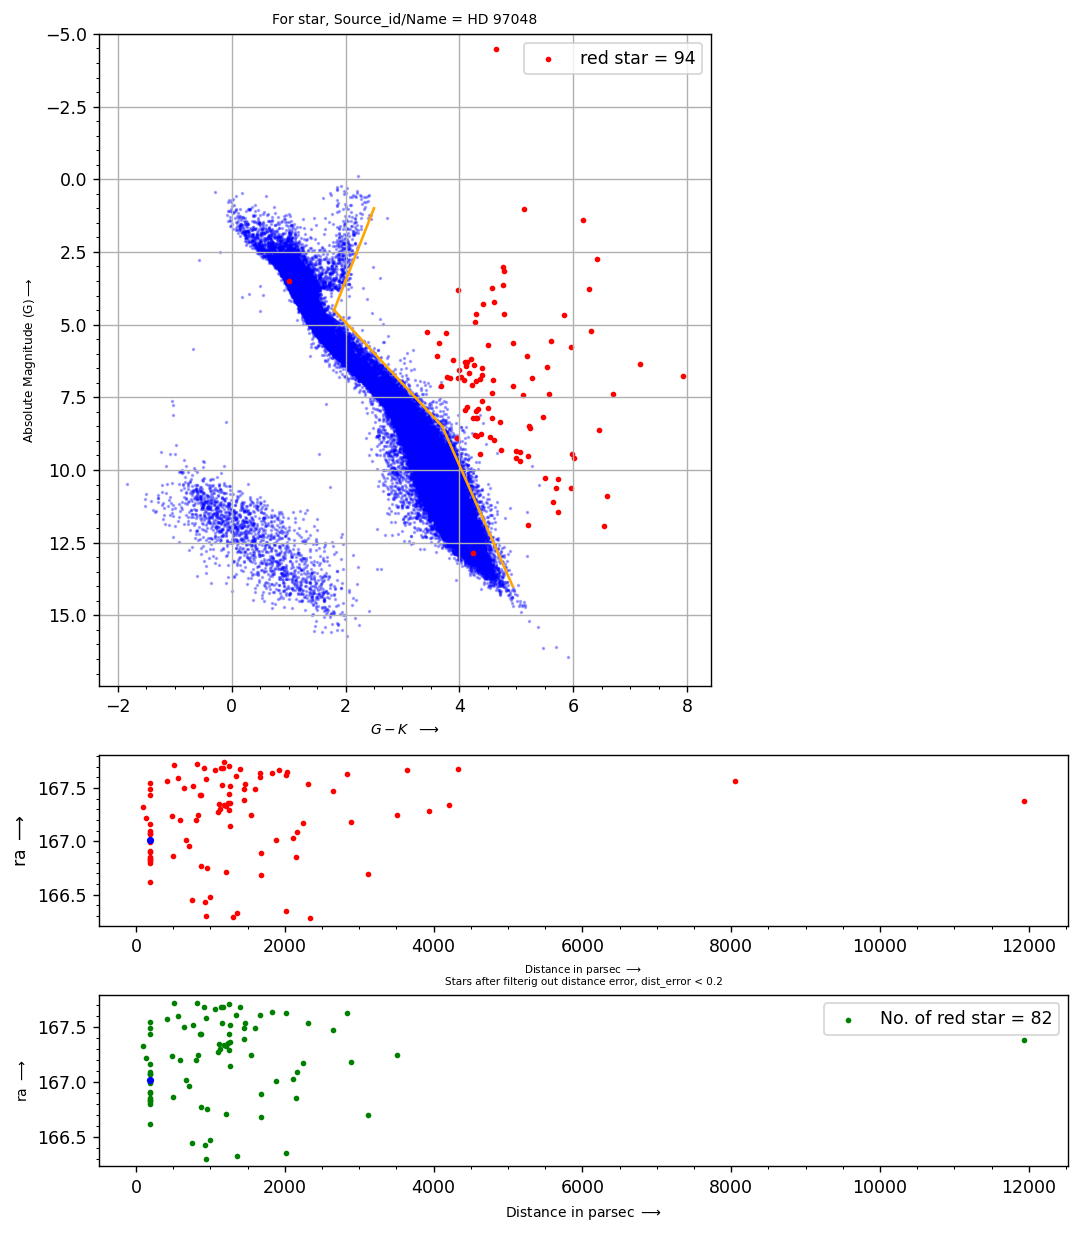

In [37]:
plot_function(herb5["RAICRS"][1], herb5["DEICRS"][1], herb5["Dist"][1], herb5["Name"][1])

### $\large{\textbf{Defining a function for finding all stars/red stars within a particular radius around a list of stars }}$

In [38]:


def list_red_object(radius):

    num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    num_red_star_her = []   # For red object around Herbig Ae/Be star
    num_tot_star_rand = []  # For toatal star around random star
    num_red_star_rand = []  # For red objec around the Random Star

    # After  distance filter

    after_num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    after_num_red_star_her = []   # For red object around Herbig Ae/Be star
    after_num_tot_star_rand = []  # For toatal star around random star
    after_num_red_star_rand = []  # For red objec around the Random Star
    


    for i in range(len(herb5.RAICRS)):

        herbig_star = get_gaia_result(1000, herb5.loc[i][1], herb5.loc[i][2], radius)
        # Filtering out stars on the basis of parallax error
        herbig_star = herbig_star[herbig_star["parallax_error"] < 0.3]
        her_mg = herbig_star["mv"]
        her_gk = herbig_star["phot_g_mean_mag"] - herbig_star["ks_m"]

        after_herbig = herbig_star[herbig_star["dist_frac"] < 0.2]
        her_mg_af = after_herbig["mv"]
        her_gk_af = after_herbig["phot_g_mean_mag"] - after_herbig["ks_m"]
        



        rand_star = get_gaia_result(1000, star5.loc[i][1], star5.loc[i][2], radius)
        rand_star = rand_star[rand_star["parallax_error"] < 0.3]
        rand_mg = rand_star["mv"]
        rand_gk = rand_star["phot_g_mean_mag"] - rand_star["ks_m"]


        after_star = rand_star[rand_star["dist_frac"] < 0.2]
        rand_mg_af = after_star["mv"]
        rand_gk_af = after_star["phot_g_mean_mag"] - after_star["ks_m"]





        # y_values1 = np.linspace(1, 4.5, 50)
        # y_values2 = np.linspace(4.5, 8.5, 100)
        # y_values3 = np.linspace(8.5, 14.5, 100)


        # fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 100, figsize = (8, 8))
        # ax.set_xlabel(r"$G - K$", fontsize = 9)
        # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 9)
        # ax.scatter(gk_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')
        # ax.scatter(her_gk, her_mg, s = 5, c = 'red', label = 'HAeBe Star')
        # ax.scatter(rand_gk, rand_mg, s = 5, c = 'black', label = 'Random Star')
        # # plotting the boundries using the eqaution of straight line
        # ax.plot(equation1(y_values1), y_values1,  color = 'orange')
        # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
        # ax.plot(equation3(y_values3), y_values3, color = 'orange')
        # ax.minorticks_on()
        # # ax.grid(True)
        # ax.legend(fontsize = 8)
        # ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
        # plt.show()
        """ Counting Red Object around a Herbig Ae/Be Star"""

        her_red_star = counting_fun(her_mg, her_gk)

        num_tot_star_her.append(len(her_mg))
        num_red_star_her.append(her_red_star)


        af_her_red = counting_fun(her_mg_af, her_gk_af)
        after_num_tot_star_her.append(len(her_mg_af))
        after_num_red_star_her.append(af_her_red)


        """ Counting Red Object around a Random Star"""
        
        rand_red_star = counting_fun(rand_mg, rand_gk)
        num_tot_star_rand.append(len(rand_mg))
        num_red_star_rand.append(rand_red_star)


        af_star_red = counting_fun(rand_mg_af, rand_gk_af)
        after_num_tot_star_rand.append(len(rand_mg_af))
        after_num_red_star_rand.append(af_star_red)


        # print("total number of red object surrounding the Herbig Star {}".format(herbig_20.loc[i][0]) + " = {}".format(num_red_stars))
        # print("Toatal surrounding stars = {}".format(len(her_mg)))


    # print("List of total stars surrounding a herbig star within 6 arcminutes = ",num_tot_star_her) 
    # print("List red stars for 20 Herbig Stars = ",num_red_star_her)
    # print("List of total stars surrounding a Random star within 6 arcminutes = ",num_tot_star_rand) 
    # print("List red stars for 20 Random stars = ",num_red_star_rand)

    return num_red_star_her, num_tot_star_her, num_red_star_rand, num_tot_star_rand, after_num_red_star_her, after_num_tot_star_her, after_num_red_star_rand, after_num_tot_star_rand
    



### $\textit{Calling the function with search radius = rad\_arcmin}$

In [39]:
rad_arcmin = 10.0
all_list = list_red_object(rad_arcmin/60.0)

In [40]:
num_red_star_her = all_list[0]
num_tot_star_her = all_list[1]
num_red_star_rand = all_list[2]
num_tot_star_rand = all_list[3]
af1 = all_list[4]
af2 = all_list[5]
af3 = all_list[6]
af4 = all_list[7]


In [41]:
print("\n")
print("-------------------------------   For Herbig Star    -----------------------------------")
print("\n")
print("Name of Herbig Star \t No of Red star    Total no of star    Fraction       After filter       No of red star        total no of star        Fraction")
print("-----------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:10s}\t". format(herb5.loc[i][0]) + "\t \t {:3d}".format(num_red_star_her[i]) + "\t \t{:3d}".format(num_tot_star_her[i]) + "\t \t \t{:0.4f}    |".format(num_red_star_her[i]/num_tot_star_her[i])
        + "\t \t {:3d}".format(af1[i]) + "\t \t{:3d}".format(af2[i]) + "\t \t \t{:0.4f}".format(af1[i]/af2[i]))

print("\n")
print(" Average number of red objects around a Herbig Star = {}".format(np.average(num_red_star_her)) + " within radius {}".format(rad_arcmin) + "      after distance filter, Avg number = {}".format(np.average(af1)) )


print(" ")


print("-----------------------------------------------------------------------------------------")
print("\n")
print("--------------------------------  For Random Star    ------------------------------------")
print("\n")
print("Sl. No. of Random Star \t No of Red star    Total no of star     Fraction        After filter        No of red star        total no of star        Fraction")
print("------------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:2d}\t".format(i+1) + "\t \t {}\t".format(num_red_star_rand[i]) + "\t \t{}".format(num_tot_star_rand[i]) + "\t \t \t{:0.4f}  |".format(num_red_star_rand[i]/num_tot_star_rand[i])
    + "\t \t {:3d}".format(af3[i]) + "\t \t{:3d}".format(af4[i]) + "\t \t \t{:0.4f}".format(af3[i]/af4[i]))


print("\n")

print(" Average number of red objects around a Random Star = {}".format(np.average(num_red_star_rand))+ " within radius {} arcminute".format(rad_arcmin) + "        after distance filter, Avg number = {}".format(np.average(af3)) )




-------------------------------   For Herbig Star    -----------------------------------


Name of Herbig Star 	 No of Red star    Total no of star    Fraction       After filter       No of red star        total no of star        Fraction
-----------------------------------------------------------------------------------------
 HD 100453 		 	 316	 	898	 	 	0.3519    |	 	 253	 	784	 	 	0.3227
 HD 97048  		 	  94	 	 96	 	 	0.9792    |	 	  82	 	 84	 	 	0.9762
 HD 179218 		 	 723	 	784	 	 	0.9222    |	 	 430	 	488	 	 	0.8811
 BO Cep    		 	 388	 	647	 	 	0.5997    |	 	 324	 	565	 	 	0.5735
 HD 36917  		 	 153	 	163	 	 	0.9387    |	 	 151	 	161	 	 	0.9379


 Average number of red objects around a Herbig Star = 334.8 within radius 10.0      after distance filter, Avg number = 248.0
 
-----------------------------------------------------------------------------------------


--------------------------------  For Random Star    ------------------------------------


Sl. No. of Random Star 	

### $\textbf{Finidng the fraction of red stars  around the herbig star as well as random star}$

In [42]:
# Creating list for storing the fractional values of red star after and before the distance filter

frac_before_herb = []
frac_before_rand = []
frac_after_herb = []
frac_after_rand = []

for i in range(len(num_red_star_her)):
    f1 = num_red_star_her[i]/num_tot_star_her[i]
    f2 = num_red_star_rand[i]/num_tot_star_rand[i]
    frac_before_herb.append(f1)
    frac_before_rand.append(f2)


    f1 = af1[i]/af2[i]
    f2 = af3[i]/af4[i]
    frac_after_herb.append(f1)
    frac_after_rand.append(f2)

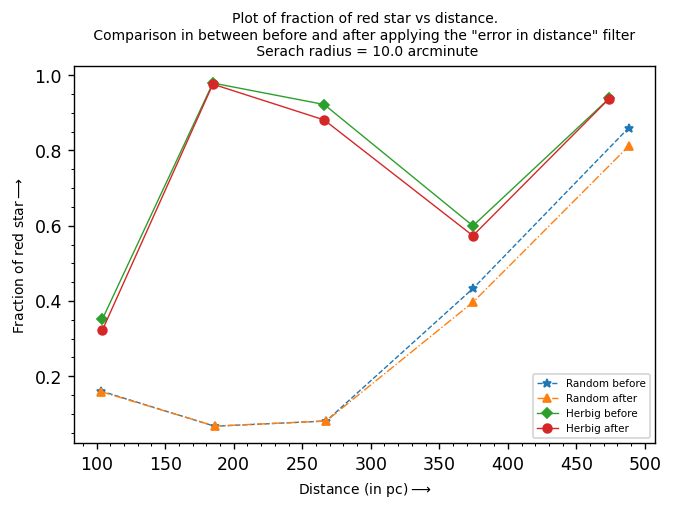

In [43]:
fig, ax = plt.subplots(dpi = 125)
ax.set_xlabel(r"Distance (in pc)$\longrightarrow$", fontsize = 8)
ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)

ax.plot(star5["r_med_photogeo"], frac_before_rand, '--', marker = "*", linewidth = 0.8, markersize = 5, label = "Random before")
ax.plot(star5["r_med_photogeo"], frac_after_rand, "-.", marker = "^", linewidth = 0.8, markersize = 5, label = "Random after")


ax.plot(herb5["Dist"], frac_before_herb, marker = "D", linewidth = 0.8, markersize = 4, label = "Herbig before")
ax.plot(herb5["Dist"], frac_after_herb, marker = "o", linewidth = 0.8, markersize = 5, label = "Herbig after")


ax.legend(fontsize = 6)
# ax.set_xscale("log")
ax.minorticks_on()
ax.set_title("""Plot of fraction of red star vs distance.\n Comparison in between before and after applying the "error in distance" filter \n Serach radius = {} arcminute""".format(rad_arcmin), fontsize = 8)
plt.show()

## $\textbf{Selecting 76 Random stars within distance of 100-500 parsec }\\ \textbf{from the 100 randomly selected stars}$

In [44]:
random_star76 = randstar_100.sample(76, replace=False)

In [45]:
random_star76 = random_star76.sort_values(by = "r_med_photogeo")
random_star76 = random_star76.reset_index(drop=True)
random_star76

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,phot_g_mean_mag
0,2267990637800956416,281.444946,74.085901,9.760830,0.059265,102.817530,102.005940,103.403170,4.957585
1,477209491229638528,65.167732,65.140422,9.490805,0.096039,106.125250,105.402030,106.787660,5.018244
2,4568140654982359424,256.574738,22.083991,9.301517,0.075648,107.419930,106.897026,107.955154,5.105988
3,4784427339626712704,70.693188,-50.481186,9.586010,0.096362,108.589310,107.613180,109.557430,4.999612
4,1366858193604257792,264.157097,48.585903,9.336958,0.073018,109.688760,109.006714,110.307490,4.965094
5,2142873125164535296,287.919322,56.859405,9.153303,0.086734,111.705400,110.660675,112.839740,4.821311
6,4581613864310894592,265.617916,24.563610,8.855957,0.095868,114.292100,113.355460,114.986570,4.973442
7,2901273846086933888,84.957580,-32.629352,8.644626,0.068243,117.141655,116.475586,117.889620,5.174418
8,6345372863360976256,327.729675,-82.719050,8.189715,0.087766,124.423096,123.575386,125.433370,5.184250
9,5580491384682907264,98.456084,-36.231598,8.070320,0.068330,125.047800,124.200980,125.984570,4.894232


In [46]:

herbig_within_500 

,Name,RAICRS,DEICRS,Dist,E_Dist,e_Dist,Max_Dist,Min_Dist
0,HD 100453,173.272917,-54.324722,104.2,0.7,0.7,104.9,103.5
1,HD 104237,180.020417,-78.193056,108.4,1.1,1.1,109.5,107.3
2,HD 100546,173.355417,-70.194722,110.0,1.0,1.0,111.0,109.0
3,HD 141569,237.490417,-3.921389,110.6,0.9,0.9,111.5,109.7
4,HD 169142,276.124167,-29.780556,114.0,1.4,1.3,115.4,112.7
5,HD 139614,235.193333,-42.498333,134.7,1.6,1.6,136.3,133.1
6,HD 135344B,228.951667,-37.154444,135.8,2.4,2.3,138.2,133.5
7,AK Sco,253.686667,-36.888611,140.6,2.1,2.0,142.7,138.6
8,HD 135344,228.953750,-37.148889,142.1,3.1,2.9,145.2,139.2
9,HD 142666,239.166667,-22.027778,148.3,2.0,1.9,150.3,146.4


In [47]:
%matplotlib inline

def list_red_object(radius):

    num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    num_red_star_her = []   # For red object around Herbig Ae/Be star
    num_tot_star_rand = []  # For toatal star around random star
    num_red_star_rand = []  # For red objec around the Random Star

    # After  distance filter

    after_num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    after_num_red_star_her = []   # For red object around Herbig Ae/Be star
    after_num_tot_star_rand = []  # For toatal star around random star
    after_num_red_star_rand = []  # For red objec around the Random Star
    


    for i in range(len(herbig_within_500.RAICRS)):

        herbig_star = get_gaia_result(1000, herbig_within_500.loc[i][1], herbig_within_500.loc[i][2], radius)
        # Filtering out stars on the basis of parallax error
        herbig_star = herbig_star[herbig_star["parallax_error"] < 0.3]
        her_mg = herbig_star["mv"]
        her_gk = herbig_star["phot_g_mean_mag"] - herbig_star["ks_m"]

        after_herbig = herbig_star[herbig_star["dist_frac"] < 0.2]
        her_mg_af = after_herbig["mv"]
        her_gk_af = after_herbig["phot_g_mean_mag"] - after_herbig["ks_m"]
        



        rand_star = get_gaia_result(1000, random_star76.loc[i][1], random_star76.loc[i][2], radius)
        rand_star = rand_star[rand_star["parallax_error"] < 0.3]
        rand_mg = rand_star["mv"]
        rand_gk = rand_star["phot_g_mean_mag"] - rand_star["ks_m"]


        after_star = rand_star[rand_star["dist_frac"] < 0.2]
        rand_mg_af = after_star["mv"]
        rand_gk_af = after_star["phot_g_mean_mag"] - after_star["ks_m"]





        # y_values1 = np.linspace(1, 4.5, 50)
        # y_values2 = np.linspace(4.5, 8.5, 100)
        # y_values3 = np.linspace(8.5, 14.5, 100)


        # fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 100, figsize = (8, 8))
        # ax.set_xlabel(r"$G - K$", fontsize = 9)
        # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 9)
        # ax.scatter(gk_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')
        # ax.scatter(her_gk, her_mg, s = 5, c = 'red', label = 'HAeBe Star')
        # ax.scatter(rand_gk, rand_mg, s = 5, c = 'black', label = 'Random Star')
        # # plotting the boundries using the eqaution of straight line
        # ax.plot(equation1(y_values1), y_values1,  color = 'orange')
        # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
        # ax.plot(equation3(y_values3), y_values3, color = 'orange')
        # ax.minorticks_on()
        # # ax.grid(True)
        # ax.legend(fontsize = 8)
        # ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
        # plt.show()
        """ Counting Red Object around a Herbig Ae/Be Star"""

        her_red_star = counting_fun(her_mg, her_gk)

        num_tot_star_her.append(len(her_mg))
        num_red_star_her.append(her_red_star)


        af_her_red = counting_fun(her_mg_af, her_gk_af)
        after_num_tot_star_her.append(len(her_mg_af))
        after_num_red_star_her.append(af_her_red)


        """ Counting Red Object around a Random Star"""
        
        rand_red_star = counting_fun(rand_mg, rand_gk)
        num_tot_star_rand.append(len(rand_mg))
        num_red_star_rand.append(rand_red_star)


        af_star_red = counting_fun(rand_mg_af, rand_gk_af)
        after_num_tot_star_rand.append(len(rand_mg_af))
        after_num_red_star_rand.append(af_star_red)


        # print("total number of red object surrounding the Herbig Star {}".format(herbig_20.loc[i][0]) + " = {}".format(num_red_stars))
        # print("Toatal surrounding stars = {}".format(len(her_mg)))


    # print("List of total stars surrounding a herbig star within 6 arcminutes = ",num_tot_star_her) 
    # print("List red stars for 20 Herbig Stars = ",num_red_star_her)
    # print("List of total stars surrounding a Random star within 6 arcminutes = ",num_tot_star_rand) 
    # print("List red stars for 20 Random stars = ",num_red_star_rand)

    return num_red_star_her, num_tot_star_her, num_red_star_rand, num_tot_star_rand, after_num_red_star_her, after_num_tot_star_her, after_num_red_star_rand, after_num_tot_star_rand
    
    


In [48]:
rad_arcmin = 6.0
all_list = list_red_object(rad_arcmin/60.0)

In [49]:
num_red_star_her = all_list[0]
num_tot_star_her = all_list[1]
num_red_star_rand = all_list[2]
num_tot_star_rand = all_list[3]
af1 = all_list[4]
af2 = all_list[5]
af3 = all_list[6]
af4 = all_list[7]

In [50]:
# Creating list for storing the fractional values of red star after and before the distance filter

frac_before_herb = []
frac_before_rand = []
frac_after_herb = []
frac_after_rand = []

for i in range(len(num_red_star_her)):

    # THIS IS FOR HERBIG STARS
    if num_tot_star_her[i] == 0:
        f1 = 0.0
        frac_before_herb.append(f1)

    else:
        f1 = num_red_star_her[i]/num_tot_star_her[i]
        frac_before_herb.append(f1)
    


    if af2[i] == 0:
        f1 = 0.0
        frac_after_herb.append(f1)
    
    else:
        f1 = af1[i]/af2[i]
        frac_after_herb.append(f1)


    # THIS IS FOR RANDOM STAR

    if num_tot_star_rand[i] == 0:
        f1 = 0.0
        frac_before_rand.append(f1)

    else:
        f1 = num_red_star_rand[i]/num_tot_star_rand[i]
        frac_before_rand.append(f1)
    


    if af4[i] == 0:
        f1 = 0.0
        frac_after_rand.append(f1)
    
    else:
        f1 = af3[i]/af4[i]
        frac_after_rand.append(f1)

    
    

    

In [51]:
her_avg_frac_bf = np.average(frac_before_herb)
her_avg_frac_af = np.average(frac_after_herb)

rnd_avg_frac_bf = np.average(frac_before_rand)
rnd_avg_frac_af = np.average(frac_after_rand)

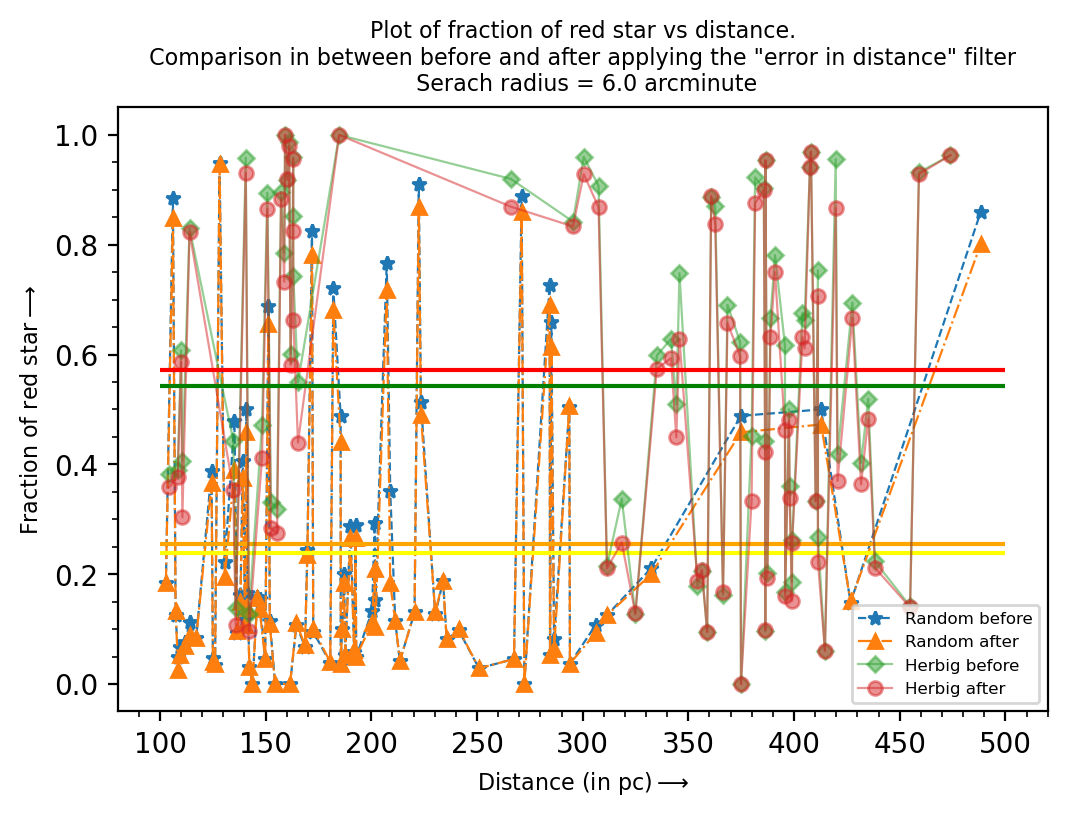

In [52]:
fig, ax = plt.subplots(dpi = 200)
ax.set_xlabel(r"Distance (in pc)$\longrightarrow$", fontsize = 8)
ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)
df_rand
ax.plot(random_star76["r_med_photogeo"], frac_before_rand, '--', marker = "*", linewidth = 0.8, markersize = 5, label = "Random before")
ax.plot(random_star76["r_med_photogeo"], frac_after_rand, "-.", marker = "^", linewidth = 0.8, markersize = 5, label = "Random after")
ax.hlines(y=rnd_avg_frac_bf, xmin=100, xmax= 500, color = 'orange')
ax.hlines(y=rnd_avg_frac_af, xmin=100, xmax= 500, color='yellow')



ax.plot(herbig_within_500["Dist"], frac_before_herb, marker = "D", linewidth = 0.8, markersize = 4, label = "Herbig before", alpha = 0.5)
ax.plot(herbig_within_500["Dist"], frac_after_herb, marker = "o", linewidth = 0.8, markersize = 5, label = "Herbig after", alpha = 0.5)
ax.hlines(y=her_avg_frac_bf, xmin=100, xmax= 500, color = 'red')
ax.hlines(y=her_avg_frac_af, xmin=100, xmax= 500, color='green')
ax.legend(fontsize = 6)
# ax.set_xscale("log")
ax.minorticks_on()
ax.set_title("""Plot of fraction of red star vs distance.\n Comparison in between before and after applying the "error in distance" filter \n Serach radius = {} arcminute""".format(rad_arcmin), fontsize = 8)
plt.show()

## $\textbf{For distance bin, 500 - 1000 parsec}$

$\textbf{Selecting Herbig star}$

In [53]:
herbig_within_1000 = df_herb[["Name", "RAICRS", "DEICRS", "Dist", "E_Dist", "e_Dist"]]

# Creating a column for storing Maximum possible distance of the herbig star from the given error

herbig_within_1000["Max_Dist"] = herbig_within_1000["Dist"] + herbig_within_1000["E_Dist"]


# Creating a column for storing Minimum possible distance of the herbig star from the given error
herbig_within_1000["Min_Dist"] = herbig_within_1000["Dist"]- herbig_within_1000["e_Dist"]

/tmp/ipykernel_4155/653969650.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  herbig_within_1000["Max_Dist"] = herbig_within_1000["Dist"] + herbig_within_1000["E_Dist"]
/tmp/ipykernel_4155/653969650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  herbig_within_1000["Min_Dist"] = herbig_within_1000["Dist"]- herbig_within_1000["e_Dist"]


In [54]:
herbig_within_1000 = herbig_within_1000[(herbig_within_1000["Dist"] > 500.0) & (herbig_within_1000["Dist"] < 1000.0)]
herbig_within_1000 = herbig_within_1000.reset_index(drop=True)

In [55]:
herbig_within_1000 = herbig_within_1000.sort_values(by="Dist")
herbig_within_1000=herbig_within_1000.reset_index(drop=True)
herbig_within_1000

,Name,RAICRS,DEICRS,Dist,E_Dist,e_Dist,Max_Dist,Min_Dist
0,WW Vul,291.495000,21.208611,503.5,16.2,14.5,519.7,489.0
1,HD 235495,320.364583,50.996667,523.9,15.3,13.9,539.2,510.0
2,VX Cas,7.877917,61.980833,536.6,18.3,16.4,554.9,520.2
3,GSC 8581-2002,131.098333,-59.949444,557.6,12.3,11.5,569.9,546.1
4,V594 Cas,10.826250,61.911111,569.2,15.6,14.2,584.8,555.0
5,LkHa 324,315.975833,50.252778,605.3,15.5,14.3,620.8,591.0
6,HD 45677,97.072500,-13.053056,620.5,40.7,33.2,661.2,587.3
7,PX Vul,291.667917,23.897500,627.4,49.8,39.1,677.2,588.3
8,PDS 69,209.432917,-39.979722,642.5,32.5,27.7,675.0,614.8
9,HD 59319,112.153333,-21.963611,668.4,39.5,32.8,707.9,635.6


#### $\textbf{Selecting Random star}$

In [56]:
star_within_1000 = df_rand_all[(df_rand_all["r_med_photogeo"] > 500.0) & (df_rand_all["r_med_photogeo"] < 1000)]
star_within_1000

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,phot_g_mean_mag
63,285884228793937280,80.094182,62.653701,2.083326,0.114929,501.16547,483.42453,520.89740,4.866877
80,534889699426804224,19.049569,71.743848,1.454783,0.095831,749.82550,709.52440,796.14790,4.895636
91,5365315790907090944,155.069590,-47.699073,1.234801,0.079274,804.55896,767.83453,838.88170,4.920254
108,474128453493428224,55.678053,59.969400,1.968791,0.109548,532.37506,513.81244,555.24207,4.955917
140,5355489661667879936,156.703736,-54.877291,1.860462,0.113391,579.05774,559.92910,596.65717,5.004322
...,...,...,...,...,...,...,...,...,...
999979,4212355489847179264,287.445638,-4.802362,1.800836,0.091262,579.12890,571.68230,588.24430,10.949372
999980,2011684311187941760,359.003697,60.683812,1.025619,0.030454,881.36410,871.74250,891.09686,10.949373
999981,4380335272864193280,257.276818,-0.851665,1.114183,0.038041,897.44635,885.78220,908.10190,10.949374
999989,5897015145657406592,214.277240,-53.353118,1.286641,0.043220,727.01590,717.42487,737.54285,10.949389


(array([35395., 34291., 33161., 32187., 30979., 29765., 29045., 27227.,
        25686., 23313.]),
 array([500.00122 , 550.000964, 600.000708, 650.000452, 700.000196,
        749.99994 , 799.999684, 849.999428, 899.999172, 949.998916,
        999.99866 ]),
 <BarContainer object of 10 artists>)

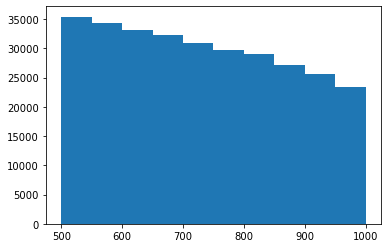

In [57]:
plt.hist(star_within_1000["r_med_photogeo"])

In [58]:
star_within_1000 = star_within_1000[((star_within_1000["r_hi_photogeo"] - star_within_1000["r_lo_photogeo"])/(2*star_within_1000["r_med_photogeo"])) < 0.01]

(array([21912., 18465., 14901., 11705.,  9099.,  6847.,  5170.,  3668.,
         2494.,  1652.]),
 array([500.00122 , 549.999728, 599.998236, 649.996744, 699.995252,
        749.99376 , 799.992268, 849.990776, 899.989284, 949.987792,
        999.9863  ]),
 <BarContainer object of 10 artists>)

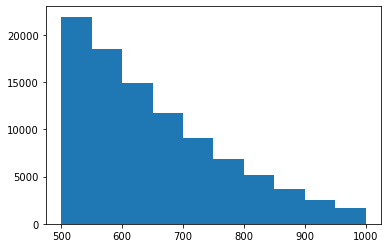

In [59]:
plt.hist(star_within_1000["r_med_photogeo"])

In [60]:
random_star50 = star_within_1000.sample(50, replace=False)

In [61]:
random_star50 = random_star50.sort_values(by="r_med_photogeo")
random_star50 = random_star50.reset_index(drop=True)

In [62]:
random_star50

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,phot_g_mean_mag
0,2142990326232579456,287.247862,57.831777,1.938981,0.022294,502.91440,500.02832,505.49783,10.890386
1,6721769164239687936,277.399820,-43.982661,2.014657,0.043966,509.20306,504.17258,513.36633,10.711308
2,5280000113854491776,96.359432,-68.737703,1.912958,0.023269,516.99010,513.07153,520.61680,9.345815
3,405778275221561216,24.563620,50.285096,1.813295,0.053540,525.13280,521.23395,529.87030,9.464290
4,5693089896589564800,123.971358,-27.628943,1.843017,0.032283,530.56530,526.08720,534.90356,10.845433
5,5629805443265199232,139.770694,-34.528898,1.779569,0.036132,538.12787,534.35376,541.85320,8.585127
6,2142488811491579648,292.626519,58.028907,1.792423,0.020253,538.73970,535.01886,541.84230,9.864941
7,4292549504292102272,291.331964,4.164675,1.733567,0.042893,544.20544,539.02170,549.73670,9.520373
8,5421187199385568768,153.335917,-37.560011,1.792451,0.037792,548.02090,542.53030,552.47200,10.065311
9,5981728088494136192,239.214355,-51.051388,1.728836,0.038018,551.83075,548.45500,555.77080,10.522505


In [63]:
random_star50.shape[0]

50

In [64]:
%matplotlib inline

def list_red_object(radius):

    num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    num_red_star_her = []   # For red object around Herbig Ae/Be star
    num_tot_star_rand = []  # For toatal star around random star
    num_red_star_rand = []  # For red objec around the Random Star

    # After  distance filter

    after_num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    after_num_red_star_her = []   # For red object around Herbig Ae/Be star
    after_num_tot_star_rand = []  # For toatal star around random star
    after_num_red_star_rand = []  # For red objec around the Random Star
    


    for i in range(len(herbig_within_1000.RAICRS)):

        herbig_star = get_gaia_result(1000, herbig_within_1000.loc[i][1], herbig_within_1000.loc[i][2], radius)
        # Filtering out stars on the basis of parallax error
        herbig_star = herbig_star[herbig_star["parallax_error"] < 0.3]
        her_mg = herbig_star["mv"]
        her_gk = herbig_star["phot_g_mean_mag"] - herbig_star["ks_m"]

        after_herbig = herbig_star[herbig_star["dist_frac"] < 0.2]
        her_mg_af = after_herbig["mv"]
        her_gk_af = after_herbig["phot_g_mean_mag"] - after_herbig["ks_m"]
        



        rand_star = get_gaia_result(1000, random_star50.loc[i][1], random_star50.loc[i][2], radius)
        rand_star = rand_star[rand_star["parallax_error"] < 0.3]
        rand_mg = rand_star["mv"]
        rand_gk = rand_star["phot_g_mean_mag"] - rand_star["ks_m"]


        after_star = rand_star[rand_star["dist_frac"] < 0.2]
        rand_mg_af = after_star["mv"]
        rand_gk_af = after_star["phot_g_mean_mag"] - after_star["ks_m"]





        # y_values1 = np.linspace(1, 4.5, 50)
        # y_values2 = np.linspace(4.5, 8.5, 100)
        # y_values3 = np.linspace(8.5, 14.5, 100)


        # fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 100, figsize = (8, 8))
        # ax.set_xlabel(r"$G - K$", fontsize = 9)
        # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 9)
        # ax.scatter(gk_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')
        # ax.scatter(her_gk, her_mg, s = 5, c = 'red', label = 'HAeBe Star')
        # ax.scatter(rand_gk, rand_mg, s = 5, c = 'black', label = 'Random Star')
        # # plotting the boundries using the eqaution of straight line
        # ax.plot(equation1(y_values1), y_values1,  color = 'orange')
        # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
        # ax.plot(equation3(y_values3), y_values3, color = 'orange')
        # ax.minorticks_on()
        # # ax.grid(True)
        # ax.legend(fontsize = 8)
        # ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
        # plt.show()
        """ Counting Red Object around a Herbig Ae/Be Star"""

        her_red_star = counting_fun(her_mg, her_gk)

        num_tot_star_her.append(len(her_mg))
        num_red_star_her.append(her_red_star)


        af_her_red = counting_fun(her_mg_af, her_gk_af)
        after_num_tot_star_her.append(len(her_mg_af))
        after_num_red_star_her.append(af_her_red)


        """ Counting Red Object around a Random Star"""
        
        rand_red_star = counting_fun(rand_mg, rand_gk)
        num_tot_star_rand.append(len(rand_mg))
        num_red_star_rand.append(rand_red_star)


        af_star_red = counting_fun(rand_mg_af, rand_gk_af)
        after_num_tot_star_rand.append(len(rand_mg_af))
        after_num_red_star_rand.append(af_star_red)


        # print("total number of red object surrounding the Herbig Star {}".format(herbig_20.loc[i][0]) + " = {}".format(num_red_stars))
        # print("Toatal surrounding stars = {}".format(len(her_mg)))


    # print("List of total stars surrounding a herbig star within 6 arcminutes = ",num_tot_star_her) 
    # print("List red stars for 20 Herbig Stars = ",num_red_star_her)
    # print("List of total stars surrounding a Random star within 6 arcminutes = ",num_tot_star_rand) 
    # print("List red stars for 20 Random stars = ",num_red_star_rand)

    return num_red_star_her, num_tot_star_her, num_red_star_rand, num_tot_star_rand, after_num_red_star_her, after_num_tot_star_her, after_num_red_star_rand, after_num_tot_star_rand
    
    


In [65]:
rad_arcmin = 6.0
all_list = list_red_object(rad_arcmin/60.0)

In [66]:
num_red_star_her = all_list[0]
num_tot_star_her = all_list[1]
num_red_star_rand = all_list[2]
num_tot_star_rand = all_list[3]
af1 = all_list[4]
af2 = all_list[5]
af3 = all_list[6]
af4 = all_list[7]

In [67]:
# Creating list for storing the fractional values of red star after and before the distance filter

frac_before_herb = []
frac_before_rand = []
frac_after_herb = []
frac_after_rand = []

for i in range(len(num_red_star_her)):

    # THIS IS FOR HERBIG STARS
    if num_tot_star_her[i] == 0:
        f1 = 0.0
        frac_before_herb.append(f1)

    else:
        f1 = num_red_star_her[i]/num_tot_star_her[i]
        frac_before_herb.append(f1)
    


    if af2[i] == 0:
        f1 = 0.0
        frac_after_herb.append(f1)
    
    else:
        f1 = af1[i]/af2[i]
        frac_after_herb.append(f1)


    # THIS IS FOR RANDOM STAR

    if num_tot_star_rand[i] == 0:
        f1 = 0.0
        frac_before_rand.append(f1)

    else:
        f1 = num_red_star_rand[i]/num_tot_star_rand[i]
        frac_before_rand.append(f1)
    


    if af4[i] == 0:
        f1 = 0.0
        frac_after_rand.append(f1)
    
    else:
        f1 = af3[i]/af4[i]
        frac_after_rand.append(f1)

    
    

    

In [68]:
her_avg_frac_bf = np.average(frac_before_herb)
her_avg_frac_af = np.average(frac_after_herb)

rnd_avg_frac_bf = np.average(frac_before_rand)
rnd_avg_frac_af = np.average(frac_after_rand)

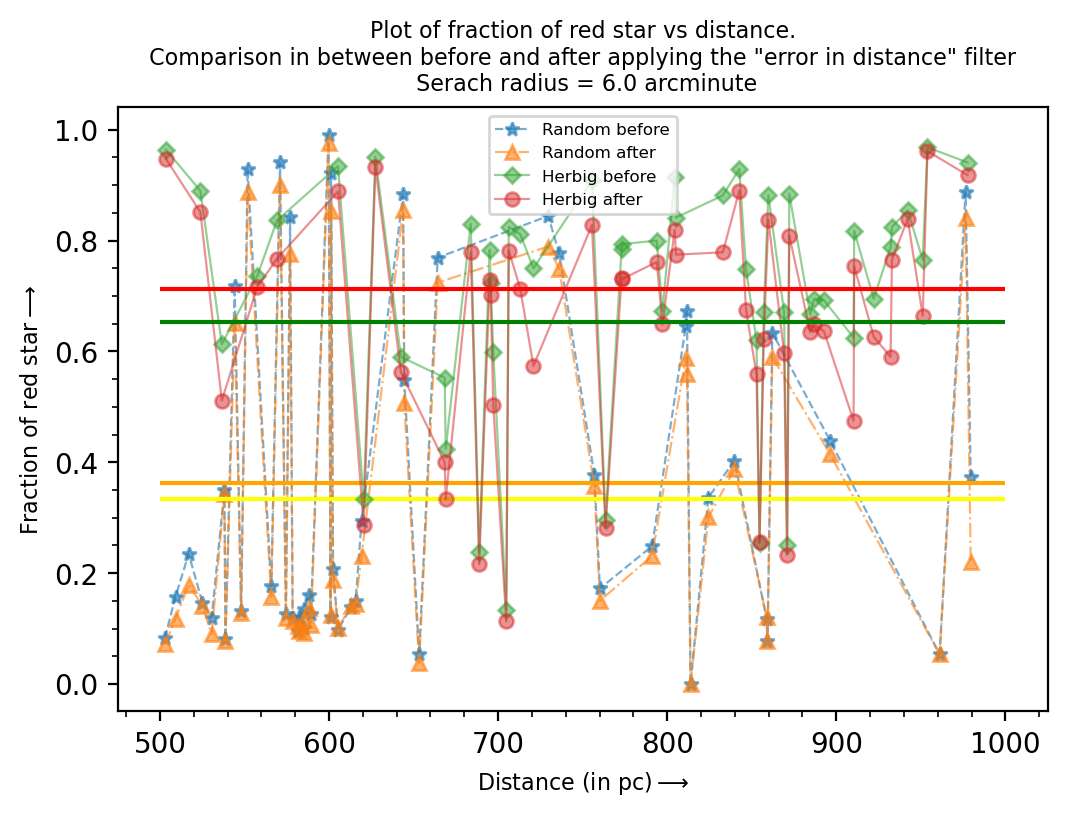

In [69]:
fig, ax = plt.subplots(dpi = 200)
ax.set_xlabel(r"Distance (in pc)$\longrightarrow$", fontsize = 8)
ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)
ax.plot(random_star50["r_med_photogeo"], frac_before_rand, '--', marker = "*", linewidth = 0.8, markersize = 5, label = "Random before", alpha = 0.6)
ax.plot(random_star50["r_med_photogeo"], frac_after_rand, "-.", marker = "^", linewidth = 0.8, markersize = 5, label = "Random after", alpha = 0.6)
ax.hlines(y=rnd_avg_frac_bf, xmin=500, xmax= 1000, color = 'orange')
ax.hlines(y=rnd_avg_frac_af, xmin=500, xmax= 1000, color='yellow')



ax.plot(herbig_within_1000["Dist"], frac_before_herb, marker = "D", linewidth = 0.8, markersize = 4, label = "Herbig before", alpha = 0.5)
ax.plot(herbig_within_1000["Dist"], frac_after_herb, marker = "o", linewidth = 0.8, markersize = 5, label = "Herbig after", alpha = 0.5)
ax.hlines(y=her_avg_frac_bf, xmin=500, xmax= 1000, color = 'red')
ax.hlines(y=her_avg_frac_af, xmin=500, xmax= 1000, color='green')
ax.legend(fontsize = 6)
# ax.set_xscale("log")
ax.minorticks_on()
ax.set_title("""Plot of fraction of red star vs distance.\n Comparison in between before and after applying the "error in distance" filter \n Serach radius = {} arcminute""".format(rad_arcmin), fontsize = 8)
plt.show()

In [70]:
def final_result(herbig_star_list, random_star_list, search_radius):
    

    def list_red_object(radius):

        num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
        num_red_star_her = []   # For red object around Herbig Ae/Be star
        num_tot_star_rand = []  # For toatal star around random star
        num_red_star_rand = []  # For red objec around the Random Star

        # After  distance filter

        after_num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
        after_num_red_star_her = []   # For red object around Herbig Ae/Be star
        after_num_tot_star_rand = []  # For toatal star around random star
        after_num_red_star_rand = []  # For red objec around the Random Star
        


        for i in range(herbig_star_list.shape[0]):

            herbig_star = get_gaia_result(1000, herbig_star_list.loc[i][1], herbig_star_list.loc[i][2], radius)
            # Filtering out stars on the basis of parallax error
            herbig_star = herbig_star[herbig_star["parallax_error"] < 0.3]
            her_mg = herbig_star["mv"]
            her_gk = herbig_star["phot_g_mean_mag"] - herbig_star["ks_m"]



            sigma_herb = herbig_star_list["e_Dist"][i]
            y1 = herbig_star_list["Dist"][i] - 2 *sigma_herb
            y2 = herbig_star_list["Dist"][i] + 2 *sigma_herb

            after_herbig = herbig_star[herbig_star["dist_frac"] < 0.2]
            after_herbig = after_herbig[(after_herbig["r_med_photogeo"] > y1) & (after_herbig["r_med_photogeo"] < y2)]
            her_mg_af = after_herbig["mv"]
            her_gk_af = after_herbig["phot_g_mean_mag"] - after_herbig["ks_m"]


            
            #-----------------------------------------------------------------------------
            rand_star = get_gaia_result(1000, random_star_list.loc[i][1], random_star_list.loc[i][2], radius)
            rand_star = rand_star[rand_star["parallax_error"] < 0.3]
            rand_mg = rand_star["mv"]
            rand_gk = rand_star["phot_g_mean_mag"] - rand_star["ks_m"]

            # -----------------------------------------
            sigma_star = (random_star_list["r_hi_photogeo"][i] - random_star_list["r_lo_photogeo"][i])/2
            x1 = random_star_list["r_med_photogeo"][i] - 2 *sigma_star
            x2 = random_star_list["r_med_photogeo"][i] + 2 *sigma_star
            after_star = rand_star[rand_star["dist_frac"] < 0.2]
            after_star = after_star[(after_star["r_med_photogeo"] > x1) & (after_star["r_med_photogeo"] < x2)]
        
            rand_mg_af = after_star["mv"]
            rand_gk_af = after_star["phot_g_mean_mag"] - after_star["ks_m"]
            
            #--------------------------------------------------------------------------------

            # y_values1 = np.linspace(1, 4.5, 50)
            # y_values2 = np.linspace(4.5, 8.5, 100)
            # y_values3 = np.linspace(8.5, 14.5, 100)


            # fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 100, figsize = (8, 8))
            # ax.set_xlabel(r"$G - K$", fontsize = 9)
            # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 9)
            # ax.scatter(gk_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')
            # ax.scatter(her_gk, her_mg, s = 5, c = 'red', label = 'HAeBe Star')
            # ax.scatter(rand_gk, rand_mg, s = 5, c = 'black', label = 'Random Star')
            # # plotting the boundries using the eqaution of straight line
            # ax.plot(equation1(y_values1), y_values1,  color = 'orange')
            # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
            # ax.plot(equation3(y_values3), y_values3, color = 'orange')
            # ax.minorticks_on()
            # # ax.grid(True)
            # ax.legend(fontsize = 8)
            # ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
            # plt.show()
            """ Counting Red Object around a Herbig Ae/Be Star"""

            her_red_star = counting_fun(her_mg, her_gk)

            num_tot_star_her.append(len(her_mg))
            num_red_star_her.append(her_red_star)


            af_her_red = counting_fun(her_mg_af, her_gk_af)
            after_num_tot_star_her.append(len(her_mg_af))
            after_num_red_star_her.append(af_her_red)


            """ Counting Red Object around a Random Star"""
            
            rand_red_star = counting_fun(rand_mg, rand_gk)
            num_tot_star_rand.append(len(rand_mg))
            num_red_star_rand.append(rand_red_star)


            af_star_red = counting_fun(rand_mg_af, rand_gk_af)
            after_num_tot_star_rand.append(len(rand_mg_af))
            after_num_red_star_rand.append(af_star_red)


            # print("total number of red object surrounding the Herbig Star {}".format(herbig_20.loc[i][0]) + " = {}".format(num_red_stars))
            # print("Toatal surrounding stars = {}".format(len(her_mg)))


        # print("List of total stars surrounding a herbig star within 6 arcminutes = ",num_tot_star_her) 
        # print("List red stars for 20 Herbig Stars = ",num_red_star_her)
        # print("List of total stars surrounding a Random star within 6 arcminutes = ",num_tot_star_rand) 
        # print("List red stars for 20 Random stars = ",num_red_star_rand)

        return num_red_star_her, num_tot_star_her, num_red_star_rand, num_tot_star_rand, after_num_red_star_her, after_num_tot_star_her, after_num_red_star_rand, after_num_tot_star_rand
        

    rad_arcmin = search_radius
    all_list = list_red_object(rad_arcmin/60.0)
    
    # -----------------------------------------------------------------------
    num_red_star_her = all_list[0]
    num_tot_star_her = all_list[1]
    num_red_star_rand = all_list[2]
    num_tot_star_rand = all_list[3]
    af1 = all_list[4]
    af2 = all_list[5]
    af3 = all_list[6]
    af4 = all_list[7]


    #-----------------------------------------------------------------------------

    # Creating list for storing the fractional values of red star after and before the distance filter

    frac_before_herb = []
    frac_before_rand = []
    frac_after_herb = []
    frac_after_rand = []

    for i in range(len(num_red_star_her)):

        # THIS IS FOR HERBIG STARS
        if num_tot_star_her[i] == 0:
            f1 = 0.0
            frac_before_herb.append(f1)

        else:
            f1 = num_red_star_her[i]/num_tot_star_her[i]
            frac_before_herb.append(f1)
        


        if af2[i] == 0:
            f1 = 0.0
            frac_after_herb.append(f1)
        
        else:
            f1 = af1[i]/af2[i]
            frac_after_herb.append(f1)


        # THIS IS FOR RANDOM STAR

        if num_tot_star_rand[i] == 0:
            f1 = 0.0
            frac_before_rand.append(f1)

        else:
            f1 = num_red_star_rand[i]/num_tot_star_rand[i]
            frac_before_rand.append(f1)
        


        if af4[i] == 0:
            f1 = 0.0
            frac_after_rand.append(f1)
        
        else:
            f1 = af3[i]/af4[i]
            frac_after_rand.append(f1)

    
    her_avg_frac_bf = np.average(frac_before_herb)
    her_avg_frac_af = np.average(frac_after_herb)

    rnd_avg_frac_bf = np.average(frac_before_rand)
    rnd_avg_frac_af = np.average(frac_after_rand)


    fig, ax = plt.subplots(dpi = 200)
    ax.set_xlabel(r"Distance (in pc)$\longrightarrow$", fontsize = 8)
    ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)
    
    ax.plot(random_star_list["r_med_photogeo"], frac_before_rand, '--', marker = "*", linewidth = 0.8, markersize = 5, label = "Random before", alpha = 0.6)
    ax.plot(random_star_list["r_med_photogeo"], frac_after_rand, "-.", marker = "^", linewidth = 0.8, markersize = 5, label = "Random after", alpha = 0.6)
    ax.hlines(y=rnd_avg_frac_bf, xmin=500, xmax= 1000, color = 'orange')
    ax.hlines(y=rnd_avg_frac_af, xmin=500, xmax= 1000, color='yellow')



    ax.plot(herbig_star_list["Dist"], frac_before_herb, marker = "D", linewidth = 0.8, markersize = 4, label = "Herbig before", alpha = 0.5)
    ax.plot(herbig_star_list["Dist"], frac_after_herb, marker = "o", linewidth = 0.8, markersize = 5, label = "Herbig after", alpha = 0.5)
    ax.hlines(y=her_avg_frac_bf, xmin=500, xmax= 1000, color = 'red')
    ax.hlines(y=her_avg_frac_af, xmin=500, xmax= 1000, color='green')
    ax.legend(fontsize = 6)
    # ax.set_xscale("log")
    ax.minorticks_on()
    ax.set_title("""Plot of fraction of red star vs distance.\n Comparison in between before and after applying the "error in distance" filter \n Serach radius = {} arcminute""".format(rad_arcmin), fontsize = 8)
    plt.show()

    
    

    
    

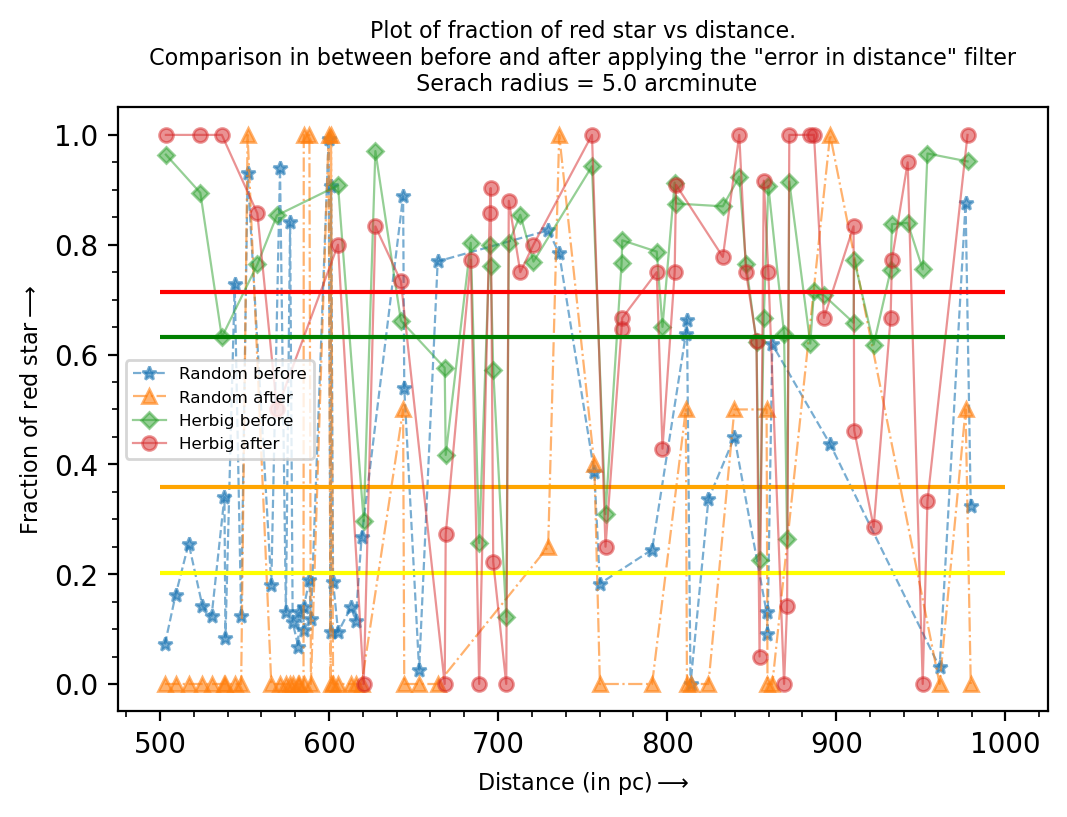

In [71]:
final_result(herbig_within_1000, random_star50, 5.0)

## $\textbf{Task for 30 August}$

In [80]:
def final_result(herbig_star_list, random_star_list, search_radius):
    

    def list_red_object(radius):

        num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
        num_red_star_her = []   # For red object around Herbig Ae/Be star
        num_tot_star_rand = []  # For toatal star around random star
        num_red_star_rand = []  # For red objec around the Random Star

        # After  distance filter

        after_num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
        after_num_red_star_her = []   # For red object around Herbig Ae/Be star
        after_num_tot_star_rand = []  # For toatal star around random star
        after_num_red_star_rand = []  # For red objec around the Random Star
        


        for i in range(herbig_star_list.shape[0]):

            herbig_star = get_gaia_result(1000, herbig_star_list.loc[i][1], herbig_star_list.loc[i][2], radius)
            # Filtering out stars on the basis of parallax error
            herbig_star = herbig_star[herbig_star["parallax_error"] < 0.3]
            her_mg = herbig_star["mv"]
            her_gk = herbig_star["phot_g_mean_mag"] - herbig_star["ks_m"]

            # Considering only those sources which lies within the 2*sigma distance error of the main source.

            sigma_herb = (herbig_star_list["e_Dist"][i] + herbig_star_list["E_Dist"][i])/2
            y1 = herbig_star_list["Dist"][i] - 2 *sigma_herb
            y2 = herbig_star_list["Dist"][i] + 2 *sigma_herb

            after_herbig = herbig_star#[herbig_star["dist_frac"] < 0.2]
            after_herbig = after_herbig[(after_herbig["r_med_photogeo"] > y1) & (after_herbig["r_med_photogeo"] < y2)]
            her_mg_af = after_herbig["mv"]
            her_gk_af = after_herbig["phot_g_mean_mag"] - after_herbig["ks_m"]


            
            #-----------------------------------------------------------------------------
            rand_star = get_gaia_result(1000, random_star_list.loc[i][1], random_star_list.loc[i][2], radius)
            rand_star = rand_star[rand_star["parallax_error"] < 0.3]
            rand_mg = rand_star["mv"]
            rand_gk = rand_star["phot_g_mean_mag"] - rand_star["ks_m"]

            # -----------------------------------------
            sigma_star = (random_star_list["r_hi_photogeo"][i] - random_star_list["r_lo_photogeo"][i])/2
            x1 = random_star_list["r_med_photogeo"][i] - 2 *sigma_star
            x2 = random_star_list["r_med_photogeo"][i] + 2 *sigma_star
            after_star = rand_star#[rand_star["dist_frac"] < 0.2]
            after_star = after_star[(after_star["r_med_photogeo"] > x1) & (after_star["r_med_photogeo"] < x2)]
        
            rand_mg_af = after_star["mv"]
            rand_gk_af = after_star["phot_g_mean_mag"] - after_star["ks_m"]
            
            #--------------------------------------------------------------------------------

            # y_values1 = np.linspace(1, 4.5, 50)
            # y_values2 = np.linspace(4.5, 8.5, 100)
            # y_values3 = np.linspace(8.5, 14.5, 100)


            # fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 100, figsize = (8, 8))
            # ax.set_xlabel(r"$G - K$", fontsize = 9)
            # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 9)
            # ax.scatter(gk_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')
            # ax.scatter(her_gk, her_mg, s = 5, c = 'red', label = 'HAeBe Star')
            # ax.scatter(rand_gk, rand_mg, s = 5, c = 'black', label = 'Random Star')
            # # plotting the boundries using the eqaution of straight line
            # ax.plot(equation1(y_values1), y_values1,  color = 'orange')
            # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
            # ax.plot(equation3(y_values3), y_values3, color = 'orange')
            # ax.minorticks_on()
            # # ax.grid(True)
            # ax.legend(fontsize = 8)
            # ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
            # plt.show()
            """ Counting Red Object around a Herbig Ae/Be Star"""

            her_red_star = counting_fun(her_mg, her_gk)

            num_tot_star_her.append(len(her_mg))
            num_red_star_her.append(her_red_star)


            af_her_red = counting_fun(her_mg_af, her_gk_af)
            after_num_tot_star_her.append(len(her_mg_af))
            after_num_red_star_her.append(af_her_red)


            """ Counting Red Object around a Random Star"""
            
            rand_red_star = counting_fun(rand_mg, rand_gk)
            num_tot_star_rand.append(len(rand_mg))
            num_red_star_rand.append(rand_red_star)


            af_star_red = counting_fun(rand_mg_af, rand_gk_af)
            after_num_tot_star_rand.append(len(rand_mg_af))
            after_num_red_star_rand.append(af_star_red)


            # print("total number of red object surrounding the Herbig Star {}".format(herbig_20.loc[i][0]) + " = {}".format(num_red_stars))
            # print("Toatal surrounding stars = {}".format(len(her_mg)))


        # print("List of total stars surrounding a herbig star within 6 arcminutes = ",num_tot_star_her) 
        # print("List red stars for 20 Herbig Stars = ",num_red_star_her)
        # print("List of total stars surrounding a Random star within 6 arcminutes = ",num_tot_star_rand) 
        # print("List red stars for 20 Random stars = ",num_red_star_rand)

        return num_red_star_her, num_tot_star_her, num_red_star_rand, num_tot_star_rand, after_num_red_star_her, after_num_tot_star_her, after_num_red_star_rand, after_num_tot_star_rand
        

    rad_arcmin = search_radius
    all_list = list_red_object(rad_arcmin/60.0)
    
    # -----------------------------------------------------------------------
    num_red_star_her = all_list[0]
    num_tot_star_her = all_list[1]
    num_red_star_rand = all_list[2]
    num_tot_star_rand = all_list[3]
    af1 = all_list[4]
    af2 = all_list[5]
    af3 = all_list[6]
    af4 = all_list[7]


    #-----------------------------------------------------------------------------

    # Creating list for storing the fractional values of red star after and before the distance filter

    frac_before_herb = []
    frac_before_rand = []
    frac_after_herb = []
    frac_after_rand = []

    for i in range(len(num_red_star_her)):

        # THIS IS FOR HERBIG STARS
        if num_tot_star_her[i] == 0:
            f1 = 0.0
            frac_before_herb.append(f1)

        else:
            f1 = num_red_star_her[i]/num_tot_star_her[i]
            frac_before_herb.append(f1)
        


        if af2[i] == 0:
            f1 = 0.0
            frac_after_herb.append(f1)
        
        else:
            f1 = af1[i]/af2[i]
            frac_after_herb.append(f1)


        # THIS IS FOR RANDOM STAR

        if num_tot_star_rand[i] == 0:
            f1 = 0.0
            frac_before_rand.append(f1)

        else:
            f1 = num_red_star_rand[i]/num_tot_star_rand[i]
            frac_before_rand.append(f1)
        


        if af4[i] == 0:
            f1 = 0.0
            frac_after_rand.append(f1)
        
        else:
            f1 = af3[i]/af4[i]
            frac_after_rand.append(f1)

    
    her_avg_frac_bf = np.average(frac_before_herb)
    her_avg_frac_af = np.average(frac_after_herb)

    rnd_avg_frac_bf = np.average(frac_before_rand)
    rnd_avg_frac_af = np.average(frac_after_rand)


    # fig, ax = plt.subplots(dpi = 300)
    # ax.set_xlabel(r"Distance (in pc)$\longrightarrow$", fontsize = 8)
    # ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)
    
    # ax.plot(random_star_list["r_med_photogeo"], frac_before_rand, '--', marker = "*", linewidth = 0.8, markersize = 5, label = "Random before", alpha = 0.6)
    # ax.plot(random_star_list["r_med_photogeo"], frac_after_rand, "-.", marker = "^", linewidth = 0.8, markersize = 5, label = "Random after", alpha = 0.6)
    # ax.hlines(y=rnd_avg_frac_bf, xmin=500, xmax= 1000, color = 'orange')
    # ax.hlines(y=rnd_avg_frac_af, xmin=500, xmax= 1000, color='yellow')



    # ax.plot(herbig_star_list["Dist"], frac_before_herb, marker = "D", linewidth = 0.8, markersize = 4, label = "Herbig before", alpha = 0.5)
    # ax.plot(herbig_star_list["Dist"], frac_after_herb, marker = "o", linewidth = 0.8, markersize = 5, label = "Herbig after", alpha = 0.5)
    # ax.hlines(y=her_avg_frac_bf, xmin=500, xmax= 1000, color = 'red')
    # ax.hlines(y=her_avg_frac_af, xmin=500, xmax= 1000, color='green')
    # ax.legend(fontsize = 6)
    # # ax.set_xscale("log")
    # ax.minorticks_on()
    # ax.set_title("""Plot of fraction of red star vs distance.\n Comparison in between before and after applying the "error in distance" filter \n Serach radius = {} arcminute""".format(rad_arcmin), fontsize = 8)
    # plt.show()


    return frac_before_herb, frac_after_herb, frac_before_rand, frac_after_rand

    
    

    

In [92]:
radius_5 = final_result(herbig_within_1000, random_star50, 5.0)
radius_7 = final_result(herbig_within_1000, random_star50, 7.0)
radius_10 = final_result(herbig_within_1000, random_star50, 10.0)

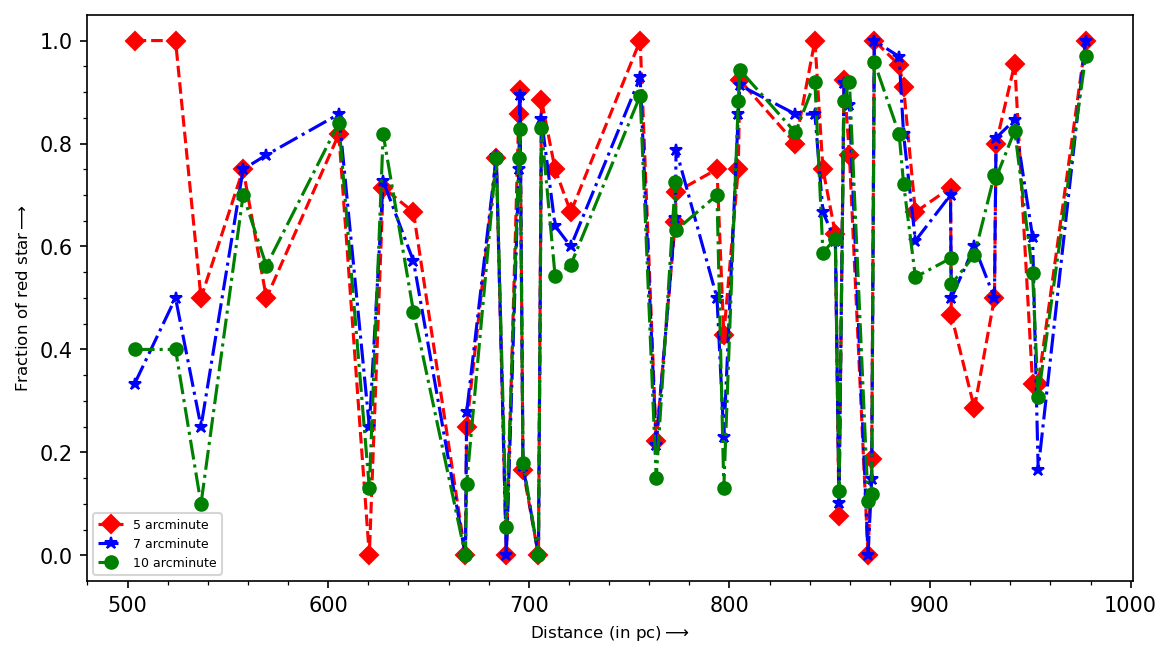

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=150, figsize = (9, 5))
ax.plot(herbig_within_1000["Dist"], radius_5[1], linestyle = '--', marker = "D", color = 'red', label = '5 arcminute')
ax.plot(herbig_within_1000["Dist"], radius_7[1], linestyle = '-.', marker = "*", color = 'blue', label = '7 arcminute')
ax.plot(herbig_within_1000["Dist"], radius_10[1], linestyle = '-.', marker = "o", color = 'green', label = '10 arcminute')
ax.set_xlabel(r"Distance (in pc)$\longrightarrow$", fontsize = 8)
ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)
ax.legend(fontsize = 6)
ax.minorticks_on()
plt.show()

### $\textbf{ Including distance variation of search radius}$

#### defing a function to get the corresponding search radius for a distance star

Assuming "Orion Nebula" as base distance = 412 pc and radius = 12 ly = 3.679 pc, this leads to angular size = 30.7 arcminute.

Our search radius = 6.0 arcminute

In [94]:
def get_arc_min(dist_star_pc):
    theta_ini = 6.0 # In arcminute
    dist_ini = 412   # In parsec
    theta_star = (dist_ini * theta_ini)/dist_star_pc

    return theta_star       # it returns parallax in arcminute

In [97]:
def final_result(herbig_star_list, random_star_list):
    


    num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    num_red_star_her = []   # For red object around Herbig Ae/Be star
    num_tot_star_rand = []  # For toatal star around random star
    num_red_star_rand = []  # For red objec around the Random Star

    # After  distance filter

    after_num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    after_num_red_star_her = []   # For red object around Herbig Ae/Be star
    after_num_tot_star_rand = []  # For toatal star around random star
    after_num_red_star_rand = []  # For red objec around the Random Star
    


    for i in range(herbig_star_list.shape[0]):
        herbig_radius = get_arc_min(herbig_star_list["Dist"][i])

        herbig_star = get_gaia_result(1000, herbig_star_list.loc[i][1], herbig_star_list.loc[i][2], herbig_radius/60.0)
        # Filtering out stars on the basis of parallax error
        herbig_star = herbig_star[herbig_star["parallax_error"] < 0.3]
        her_mg = herbig_star["mv"]
        her_gk = herbig_star["phot_g_mean_mag"] - herbig_star["ks_m"]

        # Considering only those sources which lies within the 2*sigma distance error of the main source.

        sigma_herb = (herbig_star_list["e_Dist"][i] + herbig_star_list["E_Dist"][i])/2
        y1 = herbig_star_list["Dist"][i] - 2 *sigma_herb
        y2 = herbig_star_list["Dist"][i] + 2 *sigma_herb

        after_herbig = herbig_star#[herbig_star["dist_frac"] < 0.2]
        after_herbig = after_herbig[(after_herbig["r_med_photogeo"] > y1) & (after_herbig["r_med_photogeo"] < y2)]
        her_mg_af = after_herbig["mv"]
        her_gk_af = after_herbig["phot_g_mean_mag"] - after_herbig["ks_m"]


        
        #-----------------------------------------------------------------------------
        random_radius = get_arc_min(random_star_list["r_med_photogeo"][i])
        rand_star = get_gaia_result(1000, random_star_list.loc[i][1], random_star_list.loc[i][2], random_radius/60.0)
        rand_star = rand_star[rand_star["parallax_error"] < 0.3]
        rand_mg = rand_star["mv"]
        rand_gk = rand_star["phot_g_mean_mag"] - rand_star["ks_m"]

        # -----------------------------------------
        sigma_star = (random_star_list["r_hi_photogeo"][i] - random_star_list["r_lo_photogeo"][i])/2
        x1 = random_star_list["r_med_photogeo"][i] - 2 *sigma_star
        x2 = random_star_list["r_med_photogeo"][i] + 2 *sigma_star
        after_star = rand_star#[rand_star["dist_frac"] < 0.2]
        after_star = after_star[(after_star["r_med_photogeo"] > x1) & (after_star["r_med_photogeo"] < x2)]
    
        rand_mg_af = after_star["mv"]
        rand_gk_af = after_star["phot_g_mean_mag"] - after_star["ks_m"]
        
        #--------------------------------------------------------------------------------

        # y_values1 = np.linspace(1, 4.5, 50)
        # y_values2 = np.linspace(4.5, 8.5, 100)
        # y_values3 = np.linspace(8.5, 14.5, 100)


        # fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 100, figsize = (8, 8))
        # ax.set_xlabel(r"$G - K$", fontsize = 9)
        # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 9)
        # ax.scatter(gk_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')
        # ax.scatter(her_gk, her_mg, s = 5, c = 'red', label = 'HAeBe Star')
        # ax.scatter(rand_gk, rand_mg, s = 5, c = 'black', label = 'Random Star')
        # # plotting the boundries using the eqaution of straight line
        # ax.plot(equation1(y_values1), y_values1,  color = 'orange')
        # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
        # ax.plot(equation3(y_values3), y_values3, color = 'orange')
        # ax.minorticks_on()
        # # ax.grid(True)
        # ax.legend(fontsize = 8)
        # ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
        # plt.show()
        """ Counting Red Object around a Herbig Ae/Be Star"""

        her_red_star = counting_fun(her_mg, her_gk)

        num_tot_star_her.append(len(her_mg))
        num_red_star_her.append(her_red_star)


        af_her_red = counting_fun(her_mg_af, her_gk_af)
        after_num_tot_star_her.append(len(her_mg_af))
        after_num_red_star_her.append(af_her_red)


        """ Counting Red Object around a Random Star"""
        
        rand_red_star = counting_fun(rand_mg, rand_gk)
        num_tot_star_rand.append(len(rand_mg))
        num_red_star_rand.append(rand_red_star)


        af_star_red = counting_fun(rand_mg_af, rand_gk_af)
        after_num_tot_star_rand.append(len(rand_mg_af))
        after_num_red_star_rand.append(af_star_red)



    #-----------------------------------------------------------------------------

    # Creating list for storing the fractional values of red star after and before the distance filter

    frac_before_herb = []
    frac_before_rand = []
    frac_after_herb = []
    frac_after_rand = []

    for i in range(len(num_red_star_her)):

        # THIS IS FOR HERBIG STARS
        if num_tot_star_her[i] == 0:
            f1 = 0.0
            frac_before_herb.append(f1)

        else:
            f1 = num_red_star_her[i]/num_tot_star_her[i]
            frac_before_herb.append(f1)
        


        if after_num_tot_star_her[i] == 0:
            f1 = 0.0
            frac_after_herb.append(f1)
        
        else:
            f1 = after_num_red_star_her[i]/after_num_tot_star_her[i]
            frac_after_herb.append(f1)


        # THIS IS FOR RANDOM STAR

        if num_tot_star_rand[i] == 0:
            f1 = 0.0
            frac_before_rand.append(f1)

        else:
            f1 = num_red_star_rand[i]/num_tot_star_rand[i]
            frac_before_rand.append(f1)
        


        if after_num_tot_star_rand[i] == 0:
            f1 = 0.0
            frac_after_rand.append(f1)
        
        else:
            f1 = after_num_red_star_rand[i]/after_num_tot_star_rand[i]
            frac_after_rand.append(f1)

    
    her_avg_frac_bf = np.average(frac_before_herb)
    her_avg_frac_af = np.average(frac_after_herb)

    rnd_avg_frac_bf = np.average(frac_before_rand)
    rnd_avg_frac_af = np.average(frac_after_rand)


    # fig, ax = plt.subplots(dpi = 300)
    # ax.set_xlabel(r"Distance (in pc)$\longrightarrow$", fontsize = 8)
    # ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)
    
    # ax.plot(random_star_list["r_med_photogeo"], frac_before_rand, '--', marker = "*", linewidth = 0.8, markersize = 5, label = "Random before", alpha = 0.6)
    # ax.plot(random_star_list["r_med_photogeo"], frac_after_rand, "-.", marker = "^", linewidth = 0.8, markersize = 5, label = "Random after", alpha = 0.6)
    # ax.hlines(y=rnd_avg_frac_bf, xmin=500, xmax= 1000, color = 'orange')
    # ax.hlines(y=rnd_avg_frac_af, xmin=500, xmax= 1000, color='yellow')



    # ax.plot(herbig_star_list["Dist"], frac_before_herb, marker = "D", linewidth = 0.8, markersize = 4, label = "Herbig before", alpha = 0.5)
    # ax.plot(herbig_star_list["Dist"], frac_after_herb, marker = "o", linewidth = 0.8, markersize = 5, label = "Herbig after", alpha = 0.5)
    # ax.hlines(y=her_avg_frac_bf, xmin=500, xmax= 1000, color = 'red')
    # ax.hlines(y=her_avg_frac_af, xmin=500, xmax= 1000, color='green')
    # ax.legend(fontsize = 6)
    # # ax.set_xscale("log")
    # ax.minorticks_on()
    # ax.set_title("""Plot of fraction of red star vs distance.\n Comparison in between before and after applying the "error in distance" filter \n Serach radius = {} arcminute""".format(rad_arcmin), fontsize = 8)
    # plt.show()


    return frac_before_herb, frac_after_herb, frac_before_rand, frac_after_rand

    
    

    

In [98]:
groot = final_result(herbig_within_1000, random_star50)

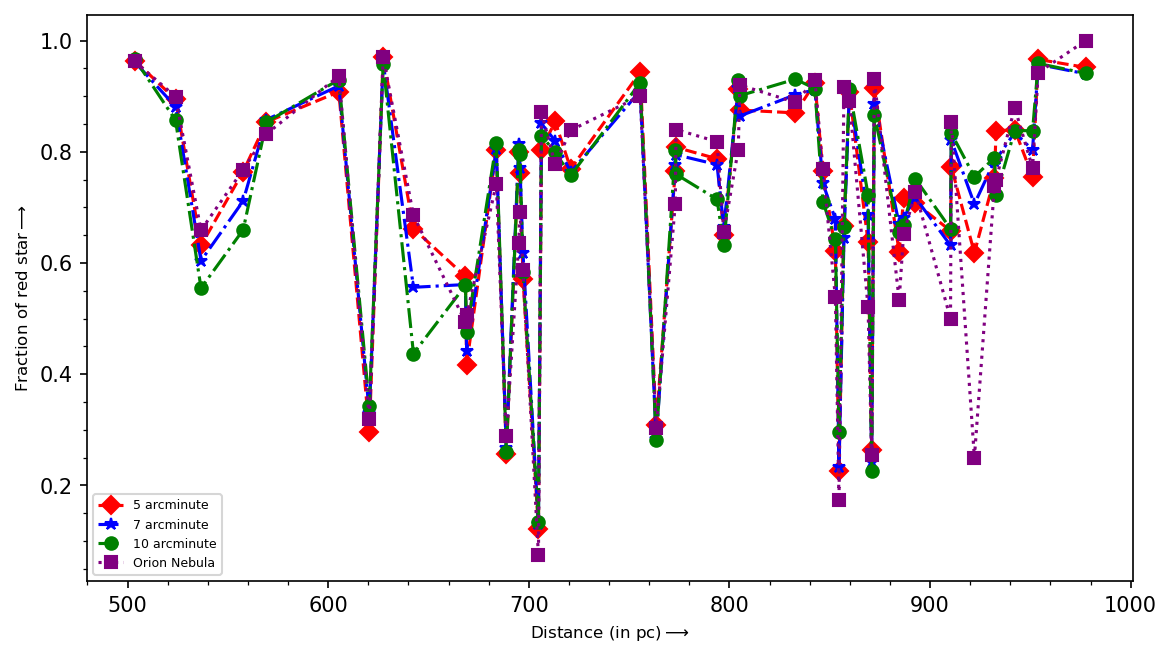

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=150, figsize = (9, 5))
ax.plot(herbig_within_1000["Dist"], radius_5[0], linestyle = '--', marker = "D", color = 'red', label = '5 arcminute')
ax.plot(herbig_within_1000["Dist"], radius_7[0], linestyle = '-.', marker = "*", color = 'blue', label = '7 arcminute')
ax.plot(herbig_within_1000["Dist"], radius_10[0], linestyle = '-.', marker = "o", color = 'green', label = '10 arcminute')
ax.plot(herbig_within_1000["Dist"], groot[0], linestyle = 'dotted', marker = "s", color = 'purple', label = 'Orion Nebula')


ax.set_xlabel(r"Distance (in pc)$\longrightarrow$", fontsize = 8)
ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)
ax.legend(fontsize = 6)
ax.minorticks_on()
plt.show()